# Accessible Consumer Credit: Predicting Payment Delays

In [60]:
import optuna
import joblib
import shap
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.functions import *
from IPython.display import Image, display
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import (
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_validate,
    cross_val_score,
    cross_val_predict,
    train_test_split,
)

params = {
    "figure.figsize": (6, 4),
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "xtick.major.size": 5,
    "ytick.major.size": 0,
    "grid.alpha": 0.8,
    "axes.grid": True,
    "axes.grid.axis": "y",
    "axes.edgecolor": "white",
}
plt.rcParams.update(params)
sns.set_palette("deep")

# Dataset Cleaning

The main objectives for this part of the notebook are:

- Get familiar with the dataset.
- Discover data quality issues.
- Decide on how to merge the different tables.

The dataset includes multiple tables containing detailed information about credit applicants, including their financial backgrounds and loan histories.

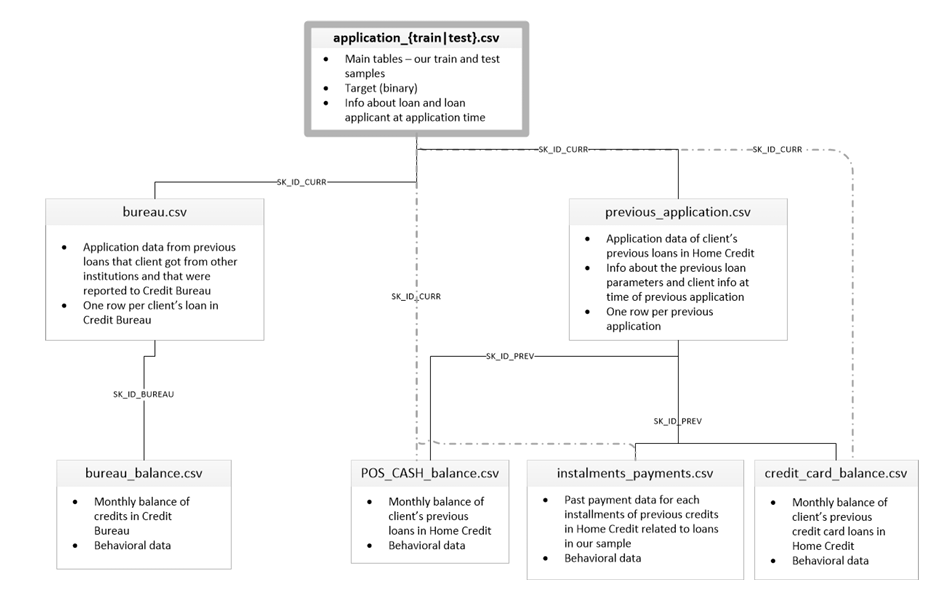

In [2]:
image_path = "pictures/dataset_structure.png"
display(Image(filename=image_path))

I examined the tables more thoroughly than what is presented, noting some interesting and unusual aspects of certain features. These observations are not a comprehensive analysis of every feature or issue but highlight a few notable points. While deeper exploration might reveal additional dataset issues, the main focus of this project is to improve model performance. Although addressing various data issues could be beneficial, it is unlikely to enhance the model's effectiveness as much as feature engineering based on extracting information from the different tables. Subsections on individual tables identify specific issues, and the actions that could address them are summarized at the end of the section.

10% of the data will be set aside for an unbiased evaluation of the model's performance at the end of the project.

In [ ]:
application_raw = pd.read_csv("application_train.csv")
application, application_test = train_test_split(
    application_raw,
    test_size=0.1,
    random_state=5,
    stratify=application_raw["TARGET"],
)
train_validation_id_curr = application["SK_ID_CURR"]

## Application

### Contents 

This table provides most direct information about each client's financial and personal background, including income, credit amount, and employment history (e.g., "AMT_INCOME_TOTAL," "AMT_CREDIT," "DAYS_EMPLOYED").

In [4]:
application_cleaner = DataCleaning(application)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
114264,232509,0,Cash loans,M,Y,N,0,225000.0,540000.0,16371.0,...,1,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
150054,273951,0,Cash loans,F,N,Y,1,110250.0,225000.0,12334.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,5.0
90167,204685,0,Cash loans,M,Y,Y,0,180000.0,225000.0,24363.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
149800,273666,1,Cash loans,M,Y,Y,1,135000.0,163008.0,17685.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
114426,232692,0,Cash loans,M,N,Y,0,225000.0,450000.0,23107.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0


DataFrame consists of 276759 rows and 122 columns.

Original data types:
float64    65
int64      41
object     16
Name: count, dtype: int64



- The "OWN_CAR_AGE" feature contains values as high as 64 and 65, which is implausible given that most clients with cars in the dataset have much newer vehicles. It’s unlikely that many people own cars this old.
- Some values in "DAYS_EMPLOYED" are set to 365243, which corresponds to retired clients according to the "NAME_INCOME_TYPE" feature. This value is inconsistent with the rest of the values, where employment days are negative.
- The "FLAG_MOBIL" feature is almost entirely filled with "1" values, indicating nearly everyone in the dataset owns a mobile phone.
- Housing-related features, such as "YEARS_BEGINEXPLUATATION_AVG" and "COMMONAREA_AVG," are challenging to interpret. For example, most values in "YEARS_BEGINEXPLUATATION_AVG" are around 0.98, with a few at 0 or around 0.47. "COMMONAREA_AVG" is typically below 0.1, with occasional outliers significantly higher. These features lack any descriptions.
- The "DAYS_LAST_PHONE_CHANGE" feature includes many zeros, which most likely do not indicate that clients changed their phones on the day of loan application.


I will visualize the proportions of late payments ("TARGET") for car ages above and below 64 years to assess whether this information is predictive of late payments. Similar analyses could be conducted for other unusual cases to evaluate their predictive value. However, as mentioned earlier, I believe it is unlikely to significantly impact the model's effectiveness.

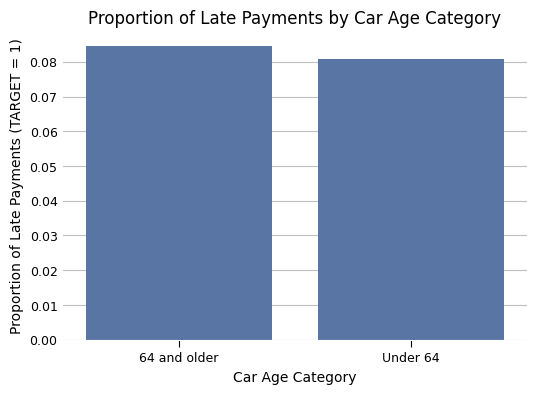

Car_Age
Under 64        273787
64 and older      2972
Name: count, dtype: int64


In [5]:
car_age = pd.DataFrame(
    {
        "Late_for_Payments": application["TARGET"],
        "Car_Age": application["OWN_CAR_AGE"].apply(
            lambda x: "64 and older" if x >= 64 else "Under 64"
        ),
    }
)
car_age_proportions = car_age.groupby("Car_Age")["Late_for_Payments"].mean()
sns.barplot(x=car_age_proportions.index, y=car_age_proportions.values, zorder=2)
plt.xlabel("Car Age Category")
plt.ylabel("Proportion of Late Payments (TARGET = 1)")
plt.title("Proportion of Late Payments by Car Age Category")
plt.show()
print(car_age["Car_Age"].value_counts())

Car age above 64 does not appear to be strongly indicative of delayed payments. This information is not particularly meaningful.

### Duplicates

In [6]:
application_cleaner.duplicates("SK_ID_CURR")

Duplicates by "SK_ID_CURR": 0, 0.00%


Each loan has a unique ID.

### Missing Values

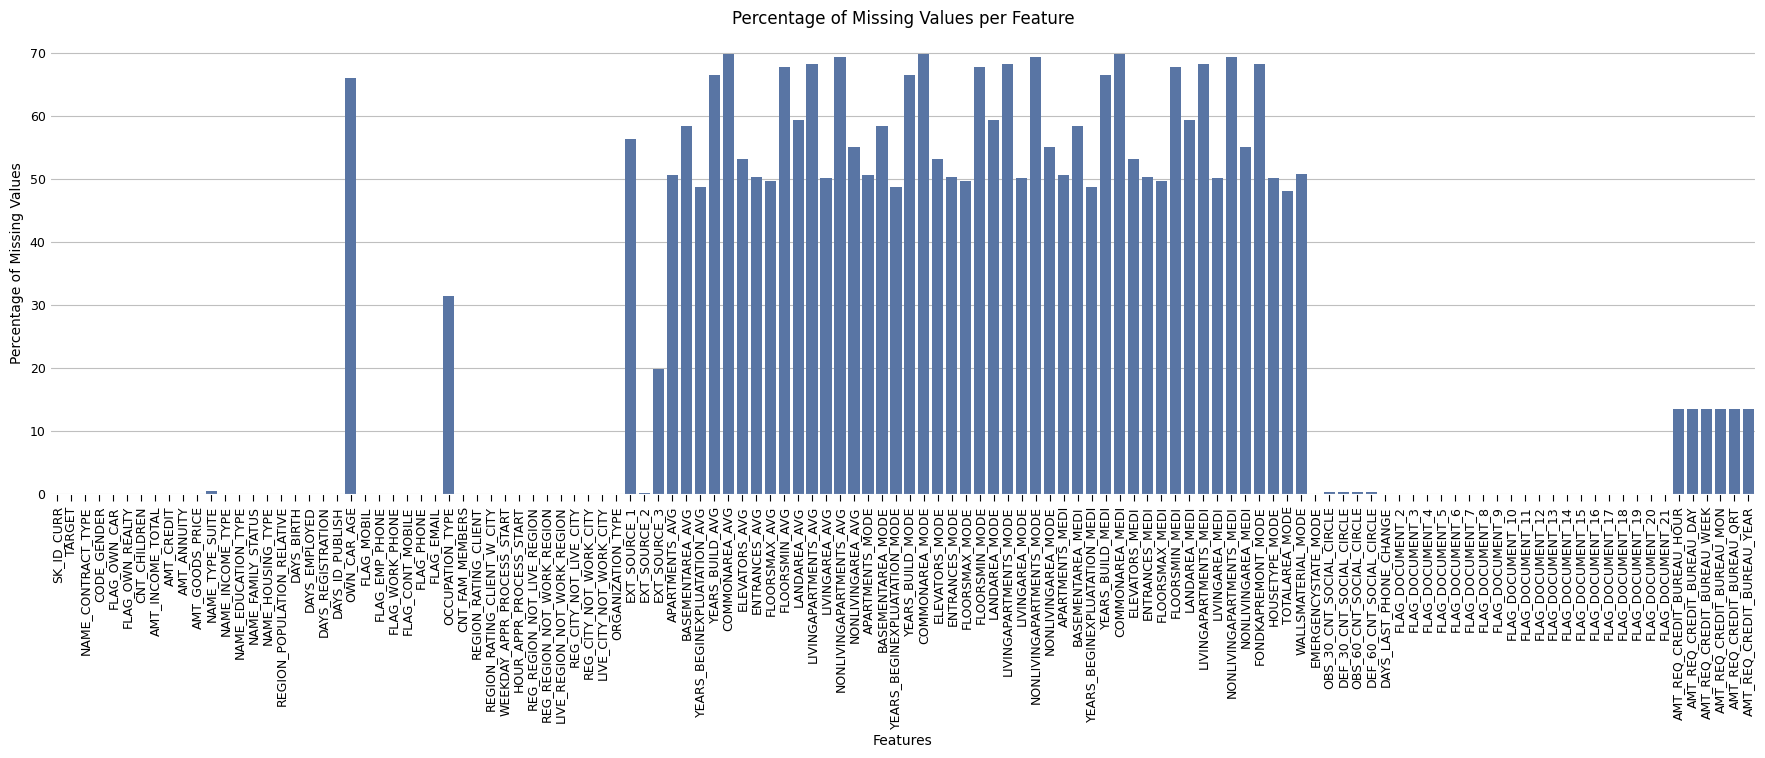

Number of missing values in categorical features: 
CODE_GENDER                        0
NAME_TYPE_SUITE                 1176
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
OCCUPATION_TYPE                86904
WEEKDAY_APPR_PROCESS_START         0
ORGANIZATION_TYPE                  0
FONDKAPREMONT_MODE            189155
HOUSETYPE_MODE                138687
WALLSMATERIAL_MODE            140530
dtype: int64

Percentage of rows with missing entries: 97.19%
Percentage of rows with more than one missing value: 89.13%
Percentage of columns with missing entries: 54.10%
Number of columns with missing entries: 66


In [7]:
application_cleaner.missing_values()

- Many numeric and categorical features have missing values.
- Some groups of features share similar patterns in the number of missing values.
- Only a small number of features are categorical.

Lets see the patterns of features with similar numbers of missing values.

In [8]:
application_cleaner.top_missing_value_groups()

Group of 6 features with 37316 missing values:
['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

Group of 4 features with 924 missing values:
['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE']

Group of 3 features with 183947 missing values:
['YEARS_BUILD_AVG', 'YEARS_BUILD_MODE', 'YEARS_BUILD_MEDI']

Group of 3 features with 152505 missing values:
['NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI']

Group of 3 features with 192120 missing values:
['NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_MEDI']



Features with the same number of missing values often contain related information, such as defaults in the social circle at different time intervals or the average, median, and mode for the same variable.

## Previous Application

This table contains information about previous loans from HomeCredit by current applicants.

### Contents

In [ ]:
previous_application_raw = pd.read_csv("previous_application.csv")
previous_application = previous_application_raw[
    previous_application_raw["SK_ID_CURR"].isin(train_validation_id_curr)
].copy()
previous_application_cleaner = DataCleaning(previous_application)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


DataFrame consists of 1272543 rows and 37 columns.

Original data types:
object     16
float64    15
int64       6
Name: count, dtype: int64



- Some of the features have a category of "XNA" indicating missing values.
- The credit conditions may differ significantly depending on the type of loan, such as revolving loans, consumer installment loans, or installment cash loans.

Lets explore the differences between the different types of loans.

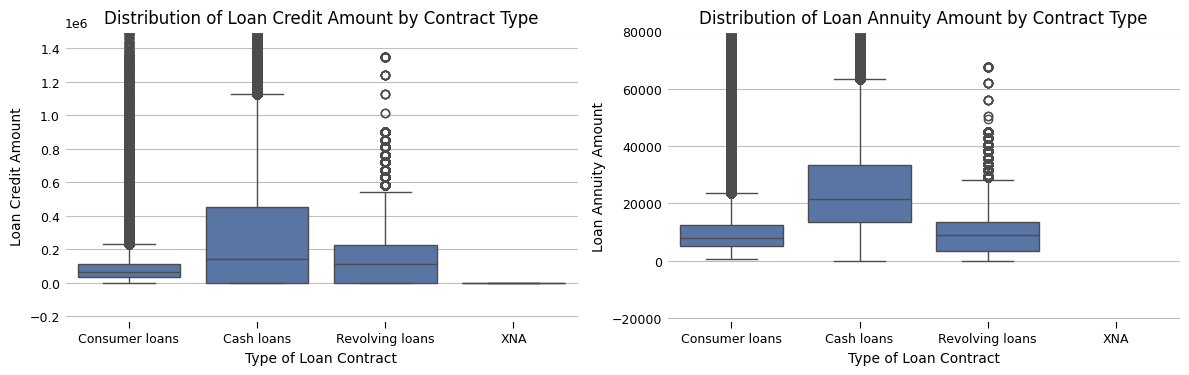

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
320227,2218188,100008,Consumer loans,17885.835,162598.5,162598.5,0.0,162598.5,THURSDAY,10,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-339.0,-69.0,-69.0,-66.0,0.0
600145,1757431,100008,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,18,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
604799,1186888,100008,Consumer loans,8019.090,44455.5,39955.5,4500.0,44455.5,MONDAY,13,...,Connectivity,6.0,low_normal,POS mobile with interest,365243.0,-2491.0,-2341.0,-2341.0,-2334.0,0.0
800095,2613879,100008,Cash loans,25309.575,450000.0,501975.0,NaN,450000.0,MONDAY,10,...,Consumer electronics,30.0,middle,Cash X-Sell: middle,365243.0,-609.0,261.0,-399.0,-388.0,1.0
906992,1907290,100008,Consumer loans,12144.285,121455.0,109309.5,12145.5,121455.0,MONDAY,9,...,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-2299.0,-2029.0,-2029.0,-703.0,0.0


Counts of contracts:

NAME_CONTRACT_TYPE
Cash loans         564535
Consumer loans     562397
Revolving loans    145329
XNA                   282
Name: count, dtype: int64


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
sns.boxplot(
    data=previous_application,
    x="NAME_CONTRACT_TYPE",
    y="AMT_CREDIT",
    ax=axes[0],
    zorder=2,
)
axes[0].set_ylim(top=1.5e6)
axes[0].set_xlabel("Type of Loan Contract")
axes[0].set_ylabel("Loan Credit Amount")
axes[0].set_title("Distribution of Loan Credit Amount by Contract Type")
sns.boxplot(
    data=previous_application,
    x="NAME_CONTRACT_TYPE",
    y="AMT_ANNUITY",
    ax=axes[1],
    zorder=2,
)
axes[1].set_ylim(top=8e4)
axes[1].set_xlabel("Type of Loan Contract")
axes[1].set_ylabel("Loan Annuity Amount")
axes[1].set_title("Distribution of Loan Annuity Amount by Contract Type")
plt.tight_layout()
plt.show()
display(previous_application[previous_application["SK_ID_CURR"] == 100008])
print("Counts of contracts:\n")
print(previous_application["NAME_CONTRACT_TYPE"].value_counts())

- In the past some clients have taken out multiple loans of different types.
- Different loan types have different typical values.

### Duplicates

In [11]:
previous_application_cleaner.duplicates("SK_ID_CURR", "SK_ID_PREV")
matching_ids(
    application,
    previous_application,
    "Application",
    "Previous Application",
    "SK_ID_CURR",
)

Duplicates by "SK_ID_CURR": 1010611, 79.42%
Duplicates by "SK_ID_PREV": 0, 0.00%
94.64% of IDs in Application are also present in Previous Application.
100.00% of IDs in Previous Application are also present in Application.


The vast majority of individuals in the dataset have previously applied for or taken out a loan with HomeCredit.

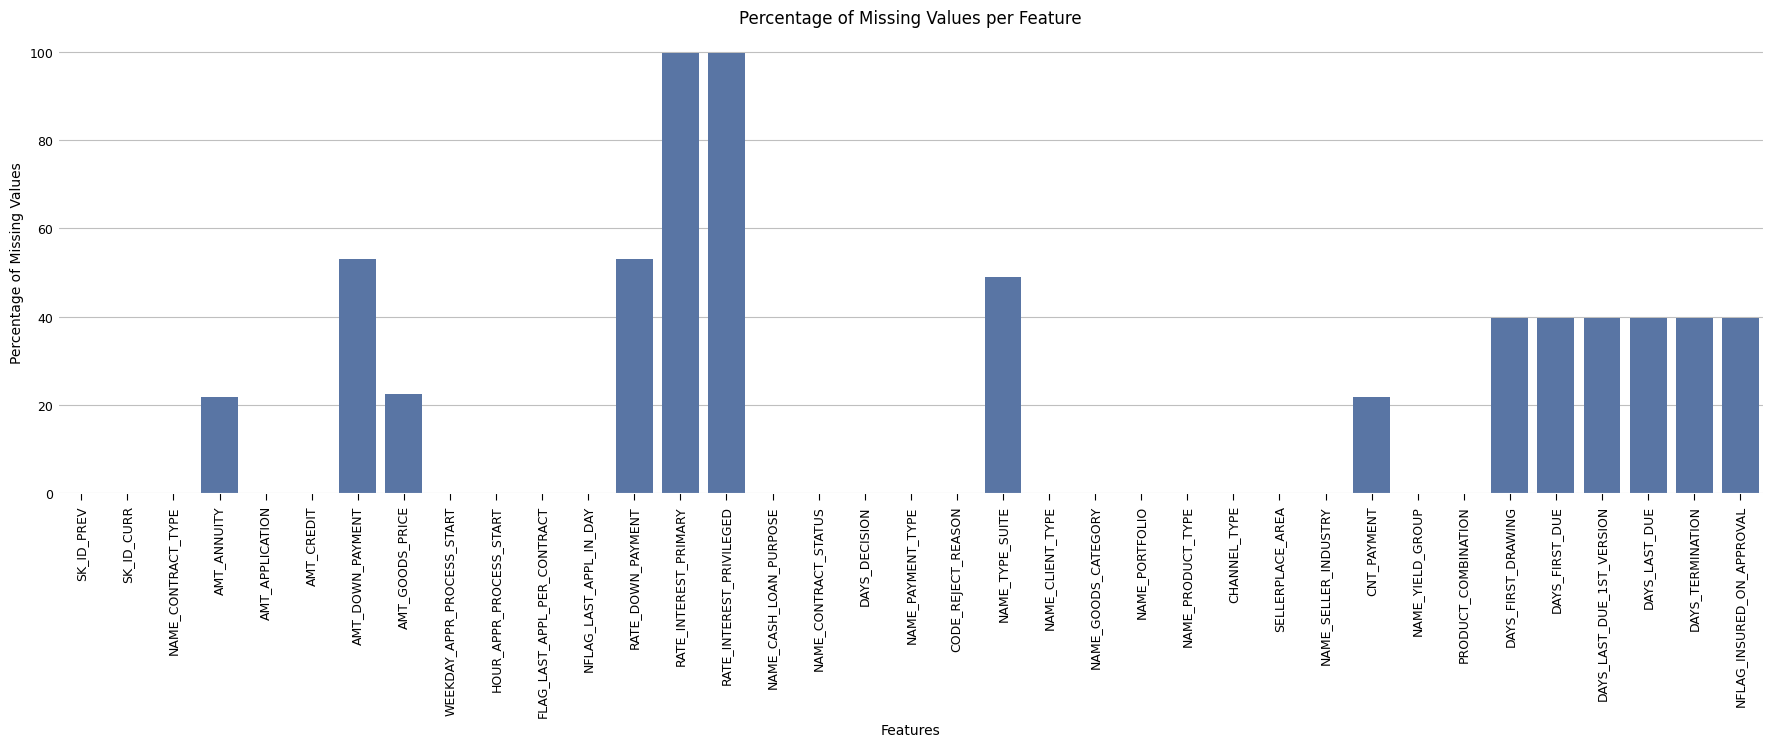

Number of missing values in categorical features: 
NAME_CONTRACT_TYPE                 0
WEEKDAY_APPR_PROCESS_START         0
NAME_CASH_LOAN_PURPOSE             0
NAME_CONTRACT_STATUS               0
NAME_PAYMENT_TYPE                  0
CODE_REJECT_REASON                 0
NAME_TYPE_SUITE               624900
NAME_CLIENT_TYPE                   0
NAME_GOODS_CATEGORY                0
NAME_PORTFOLIO                     0
NAME_PRODUCT_TYPE                  0
CHANNEL_TYPE                       0
NAME_SELLER_INDUSTRY               0
NAME_YIELD_GROUP                   0
PRODUCT_COMBINATION              282
dtype: int64

Percentage of rows with missing entries: 100.00%
Percentage of rows with more than one missing value: 99.68%
Percentage of columns with missing entries: 40.54%
Number of columns with missing entries: 15


In [12]:
previous_application_cleaner.missing_values()

Some feature values related to credit repayments, such as "AMT_ANNUITY," "NAME_CASH_LOAN_PURPOSE," and "AMT_CREDIT," contain zeros or are missing (in the case of "AMT_ANNUITY"). This raises the question of whether these clients in the dataset do not actually have previous loans, even though they are included in the data.

Let's check how many IDs in the main application table would be affected if this information were removed to determine if it's worth investigating further.

In [13]:
missing_or_zero_condition = (
    previous_application[["AMT_ANNUITY", "AMT_APPLICATION", "AMT_CREDIT"]]
    .apply(lambda x: (x.isna()) | (x == 0))
    .all(axis=1)
)
previous_application_without_missing = previous_application[~missing_or_zero_condition]
ids_dropped = (
    previous_application["SK_ID_CURR"].nunique()
    - previous_application_without_missing["SK_ID_CURR"].nunique()
)
percentage_dropped = round(
    ids_dropped / previous_application["SK_ID_CURR"].nunique() * 100, 2
)
print(
    f'Percentage of "SK_ID_CURR" entries that would be dropped if all rows where '
    f'"AMT_ANNUITY", "AMT_APPLICATION", and "AMT_CREDIT" are missing or zero are removed: {percentage_dropped}%.'
)

Percentage of "SK_ID_CURR" entries that would be dropped if all rows where "AMT_ANNUITY", "AMT_APPLICATION", and "AMT_CREDIT" are missing or zero are removed: 0.08%.


- In total, only 0.08% of loans are removed, which is a small amount.
- I also trained a model after dropping these instances, followed by grouping and aggregating the remaining data. However, this approach did not result in a significant improvement in performance. Given the time-intensive nature of aggregation and grouping, this step was excluded from the final project.

## Bureau

### Contents

This table contains information about previous loans taken by current applicants from lenders other than HomeCredit.

In [ ]:
bureau_raw = pd.read_csv("bureau.csv")
bureau = bureau_raw[bureau_raw["SK_ID_CURR"].isin(train_validation_id_curr)].copy()
bureau_cleaner = DataCleaning(bureau)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


DataFrame consists of 1318405 rows and 17 columns.

Original data types:
float64    8
int64      6
object     3
Name: count, dtype: int64



- There’s an unusual distribution of zeros and NaNs in the "AMT_CREDIT_SUM_DEBT" and "AMT_CREDIT_SUM_LIMIT" columns. Some loans are marked as active, yet those individuals apparently do not owe any money.
- The distinction between zero and NaN in "AMT_CREDIT_SUM_DEBT" and "AMT_CREDIT_SUM_LIMIT" is unclear, making it difficult to interpret what they meant, but since we have the time data of loan requests, we can assume that everyone at least attempted to secure a loan.

There is also a feature indicating the loan currency, which is important because averaging values across multiple currencies would result in meaningless aggregates due to differences in exchange rates. I will check how many people have taken loans in different currencies.

In [15]:
currency_groups = bureau.groupby("SK_ID_CURR")["CREDIT_CURRENCY"].nunique()
percentage_multi_currency = round(
    currency_groups[currency_groups > 1].count() / len(bureau) * 100, 2
)
print(
    f"Percentage of clients with loans in more than one currency is {percentage_multi_currency}%."
)

Percentage of clients with loans in more than one currency is 0.06%.


There aren't many individuals who took loans in multiple currencies.

### Duplicates

In [16]:
bureau_cleaner.duplicates("SK_ID_CURR", "SK_ID_BUREAU")
matching_ids(application, bureau, "Application", "Bureau", "SK_ID_CURR")

Duplicates by "SK_ID_CURR": 1081211, 82.01%
Duplicates by "SK_ID_BUREAU": 0, 0.00%
85.70% of IDs in Application are also present in Bureau.
100.00% of IDs in Bureau are also present in Application.


This suggests that most clients in our sample have previously applied for loans with other companies, contradicting HomeCredit’s claim of focusing on clients with limited prior loan history.

## Bureau Balance

Table shows monthly balance updates for each previous credite not by HomeCredit.

In [17]:
bureau_balance_raw = pd.read_csv("bureau_balance.csv")
bureau_balance = bureau_balance_raw[
    bureau_balance_raw["SK_ID_BUREAU"].isin(bureau["SK_ID_BUREAU"])
].copy()
bureau_balance_cleaner = DataCleaning(bureau_balance)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


DataFrame consists of 13219085 rows and 3 columns.

Original data types:
int64     2
object    1
Name: count, dtype: int64



- Some IDs only show the status "C," indicating that the loan installments are finished. This status is repeated for many months without any other entries to suggest that actual annuities were being paid during that time.
- Even though this table has no NaN values, a significant amount of missing information is represented by "X".

### Duplicates

In [18]:
bureau_balance_cleaner.duplicates("SK_ID_BUREAU")
matching_ids(bureau, bureau_balance, "Bureau", "Bureau Balance", "SK_ID_BUREAU")

Duplicates by "SK_ID_BUREAU": 12748149, 96.44%
35.72% of IDs in Bureau are also present in Bureau Balance.
100.00% of IDs in Bureau Balance are also present in Bureau.


More than half of the entries in the bureau table do not have a corresponding history log.

## POS CASH Balance

This table focuses on the monthly status of loans given out by the HomeCredit.

In [ ]:
pos_cash_balance_raw = pd.read_csv("POS_CASH_balance.csv")
pos_cash_balance = pos_cash_balance_raw[
    pos_cash_balance_raw["SK_ID_CURR"].isin(train_validation_id_curr)
].copy()
pos_cash_balance_cleaner = DataCleaning(pos_cash_balance)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


DataFrame consists of 7690656 rows and 8 columns.

Original data types:
int64      5
float64    2
object     1
Name: count, dtype: int64



Some entries in the data lack the most recent information, as they do not include records ending with "-1".

## Summary

> Missing values.

The tables contain missing information, including key details about certain credits. I will focus on the "application" table to determine the most effective imputation strategy and then apply it to the other tables. This table will have the greatest impact on predictions, as it provides the most direct information. For the relatively few categorical features, I will impute missing values using the mode without further experimentation.

> Merging tables.

 Most tables can be directly merged with the "application" table on "SK_ID_CURR," except for "bureau_balance," which must first be merged with "bureau." I will also group the data on "NAME_CONTRACT_TYPE" for the installments payments table. Grouping on "CREDIT_CURRENCY" in the bureau table could be beneficial but would affect only a small amount of data.

> Data quality issues.
 
There are various inconsistencies in the data that would benefit from consultation with domain experts. However, addressing these edge cases is unlikely to have a significant impact on model performance, so I will not prioritize this. Examples include:
- Handling "OWN_CAR_AGE" values above 64 by creating a flag feature to indicate values exceeding this threshold and treating them as missing.
- Replacing the value 365243 in "DAYS_EMPLOYED" (and other features with this placeholder) with missing values, as this feature currently does not have other missing indicators.
- Replacing zeros in "DAYS_LAST_PHONE_CHANGE" with missing values, as this feature also does not have them yet.
- Leaving "XNA" values in the installments payments table unchanged, as tree-based models can effectively split data in both cases. Additionally, for feature engineering, grouping by "NAME_CONTRACT_TYPE" is necessary and if "XNA" were treated as missing, this category would not be created.
- After merging the datasets, discrepancies arise between the "CREDIT_ACTIVE" column in the bureau dataset and the most recent "MONTHS_BALANCE" entry in the bureau_balance dataset regarding loan repayment status. In some cases, one dataset indicates that installments are complete, while the other suggests they are not. This inconsistency might be due to repayment statuses not being updated after the final payment. However, it highlights potential concerns about the overall data quality.

# EDA

The main objectives for this part of the notebook are:

- Present the ten most useful features in the model.

This was the final step in the project, with features selected based on SHAP values. These features were either highly important on their own, aggregations from different tables, or key components of significant engineered features. A more detailed discussion of feature importance, including the features presented here, will be in the project conclusions.

In [20]:
most_important_features = pd.read_csv("most_important_features.csv")
most_important_features.head()

,Late Payment Status,External Risk Source 2,Late Payment Ratio,Amount of Credit,Goods Price,Gender,Days Employed,Annuity,Education Level,Avg Remaining Instalments (Last 5),Avg Remaining Debt (Bureau)
0,No,0.661128,0.000000,540000.0,540000.0,M,-2479,16371.0,Secondary / secondary special,2.0,134368.45875
1,No,0.520393,0.303030,225000.0,225000.0,F,-234,12334.5,Secondary / secondary special,39.6,0.00000
2,No,0.533894,0.067416,225000.0,225000.0,M,-1049,24363.0,Secondary / secondary special,2.0,0.00000
3,Yes,0.089947,0.000000,163008.0,144000.0,M,-1242,17685.0,Higher education,7.2,0.00000
4,No,0.352716,0.000000,450000.0,450000.0,M,-1593,23107.5,Higher education,2.0,0.00000


Variable names have been renamed to make it clearer what they represent.

## Target Variable

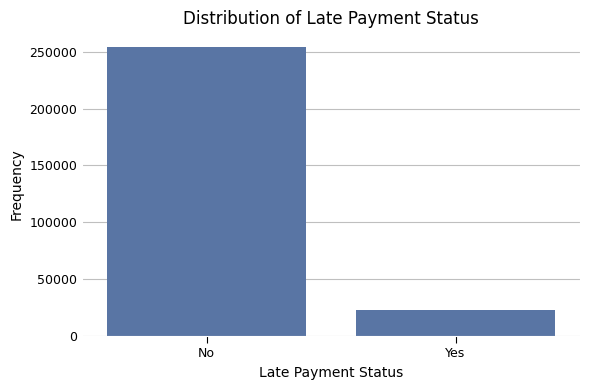

In [21]:
sns.countplot(data=most_important_features, x="Late Payment Status", zorder=2)
plt.title("Distribution of Late Payment Status")
plt.ylabel("Frequency")
plt.tight_layout()

The target variable is imbalanced.

## Relationships Between Target and Categorical Predictors

The chi-square test will be used to assess whether there are significant differences between two groups of categorical data. If there are multiple groups, the test would not specify which exact groups differ only that there is at least one statistically significant difference.

Assumptions for the chi-square hypothesis test:

- Independence: Each loan has a unique ID, meaning that all data points are independent and not related to each other.
- Expected Frequency at least 5: The counts of each category in each group are visible from the bar plots on the left. The assumption is valid for all relationships.
- Categorical Data: Our data is categorical.
- Adequate Sample Size: Since the second assumption (expected frequency) is met, the fourth assumption is generally not a concern.

Null Hypothesis (H0): There is no association between the predictor and the target variable.

Alternative Hypothesis (H1): There is an association between the predictor and the target variable.

Significance level of 0.05 will be used to test these hypotheses. If the p-value calculated from the chi-square test is less than 0.05, we will reject the null hypothesis in favor of the alternative hypothesis.

Example: In the case of gender and being late for monthly loan installments (shown below), the p-value is below the significance level. We reject the null hypothesis and conclude that there is at least one statistically significant difference between debtors gender and whether or not individuals were late for repayments.

It is important to note that, due to the large size of the dataset, all associations are statistically significant.

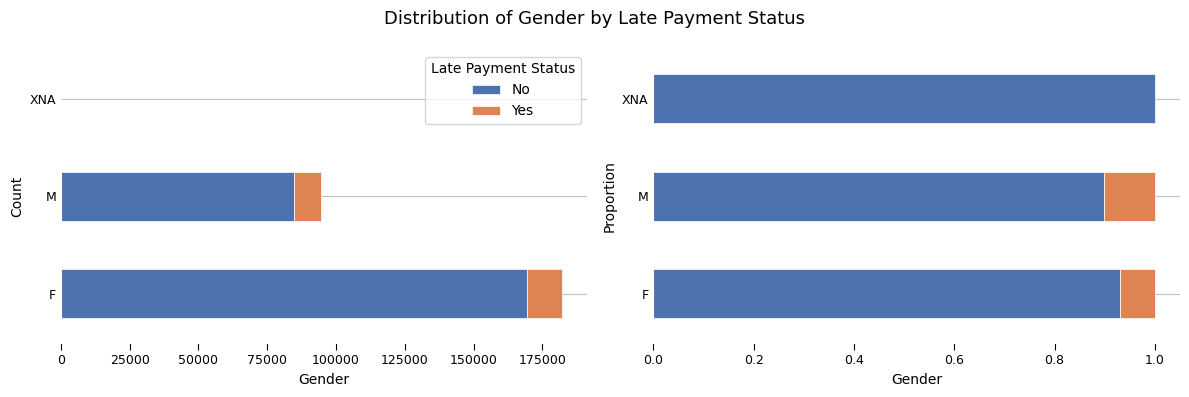

Gender - Late Payment Status:
Chi-Square test p-value: 0.00



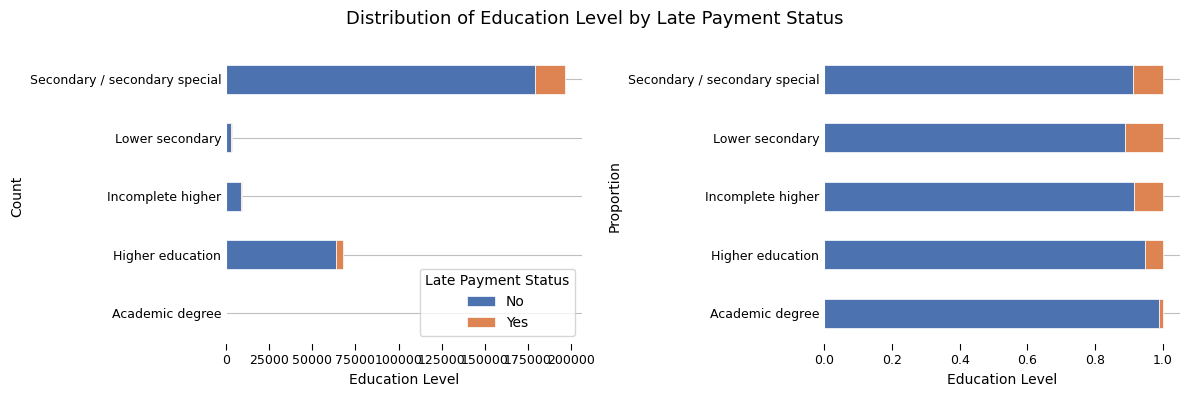

Education Level - Late Payment Status:
Chi-Square test p-value: 0.00



In [22]:
categorical_relationships(most_important_features, "Late Payment Status")

## Relationships Between Target and Numeric Variables

Numeric distributions have many extreme outliers, which will be excluded from the visualizations. Without excluding them histograms would appear empty.

A permutation hypothesis test will be used to determine if there is a significant difference in medians between the late-paying and on-time-paying segments.

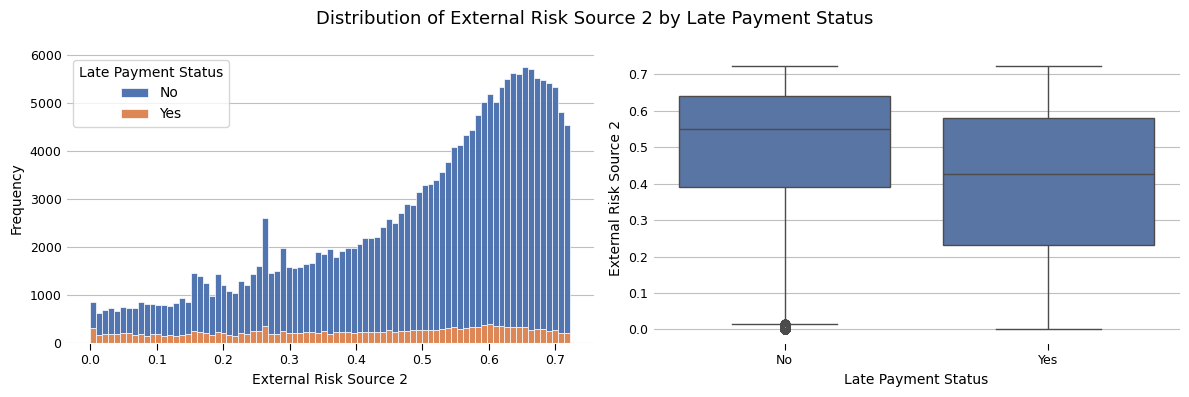

Medians for External Risk Source 2 by Late Payment Status:
No: 0.55
Yes: 0.43
Bootstrap hypothesis test p-value: 0.00


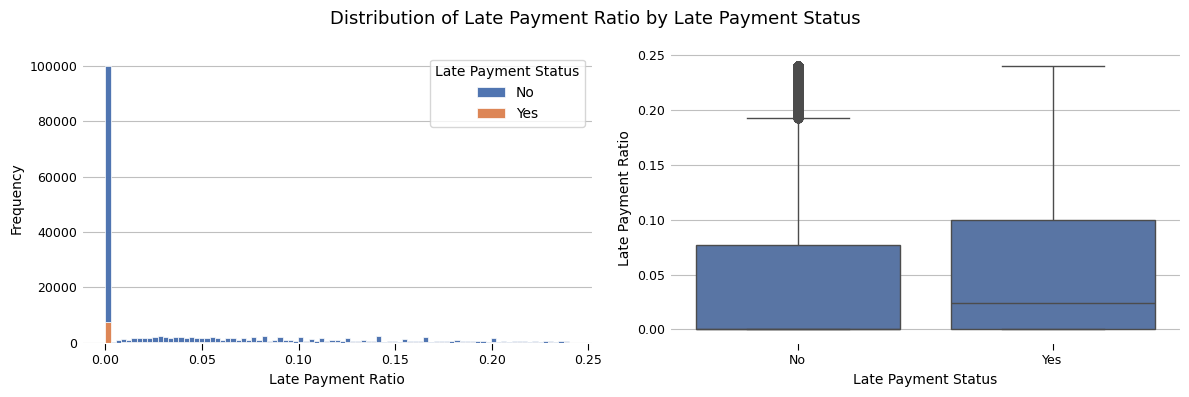

Medians for Late Payment Ratio by Late Payment Status:
No: 0.00
Yes: 0.02
Bootstrap hypothesis test p-value: 0.00


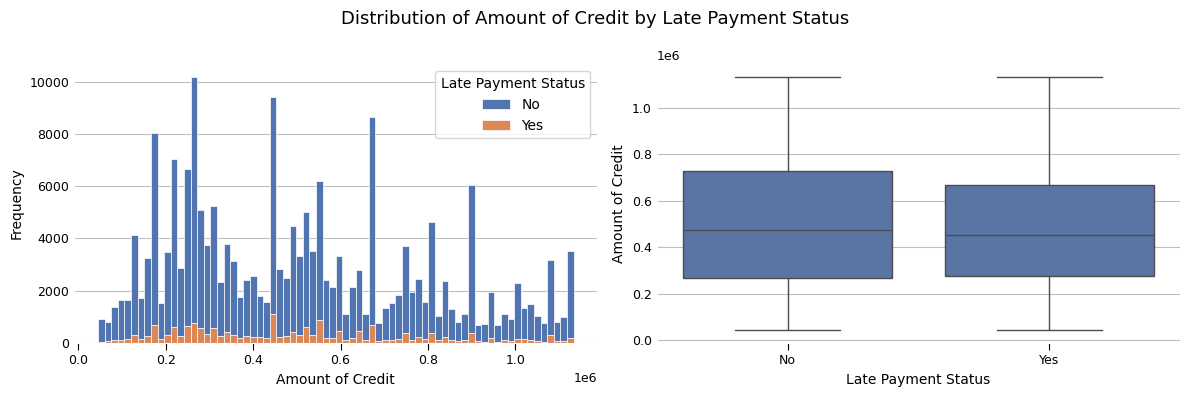

Medians for Amount of Credit by Late Payment Status:
No: 473760.00
Yes: 454500.00
Bootstrap hypothesis test p-value: 0.00


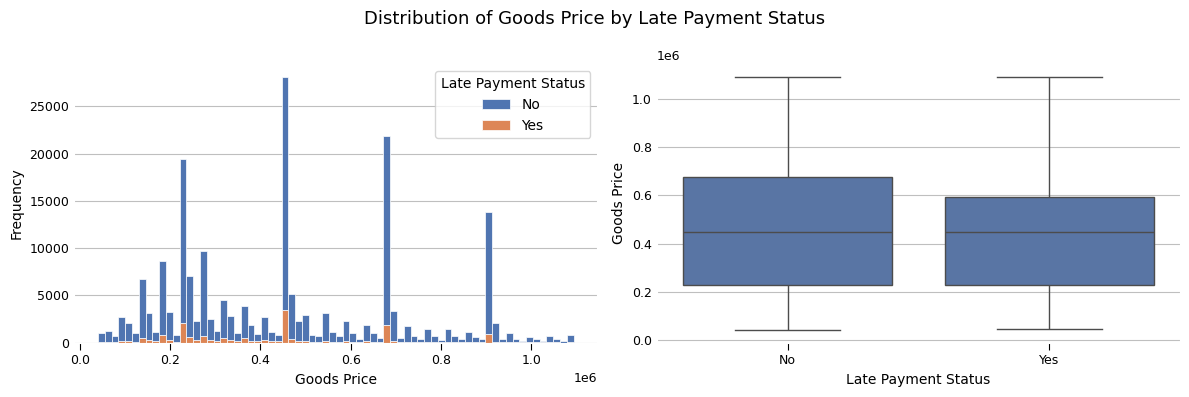

Medians for Goods Price by Late Payment Status:
No: 450000.00
Yes: 450000.00
Bootstrap hypothesis test p-value: 0.00


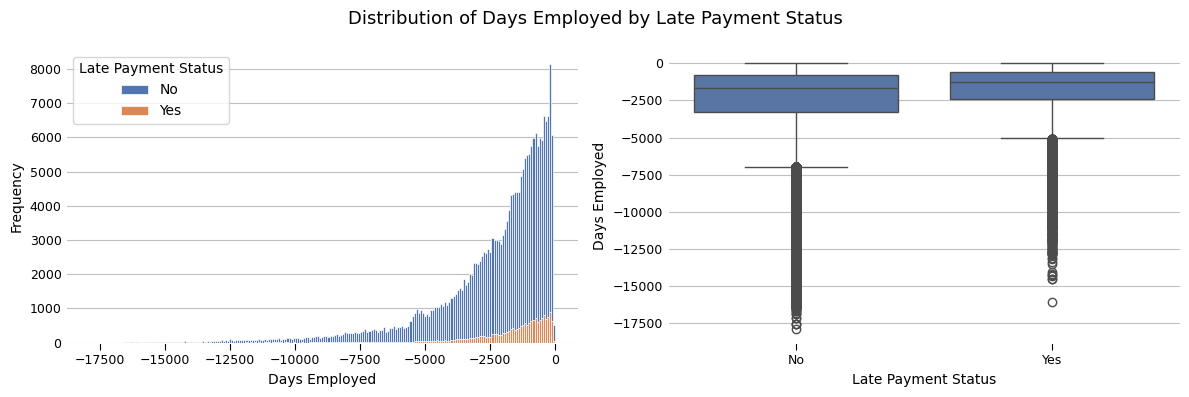

Medians for Days Employed by Late Payment Status:
No: -1692.00
Yes: -1230.00
Bootstrap hypothesis test p-value: 0.00


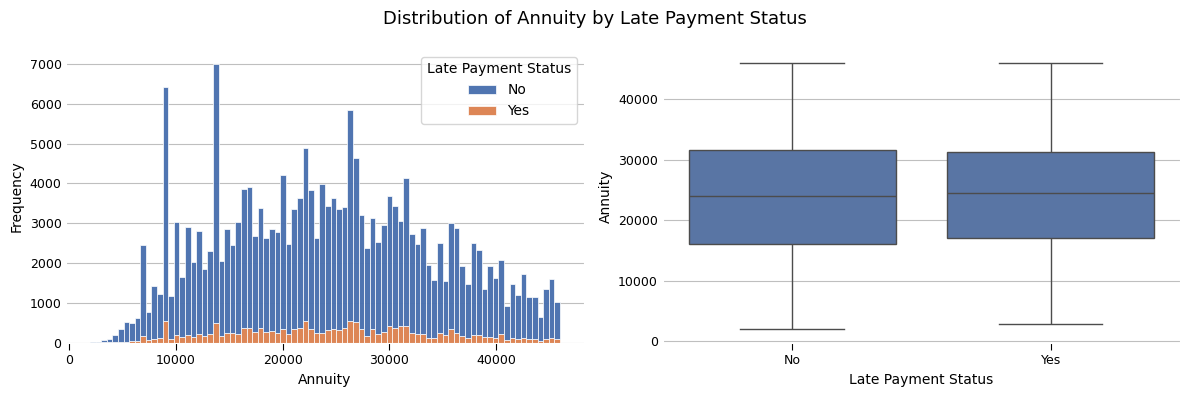

Medians for Annuity by Late Payment Status:
No: 23985.00
Yes: 24588.00
Bootstrap hypothesis test p-value: 0.00


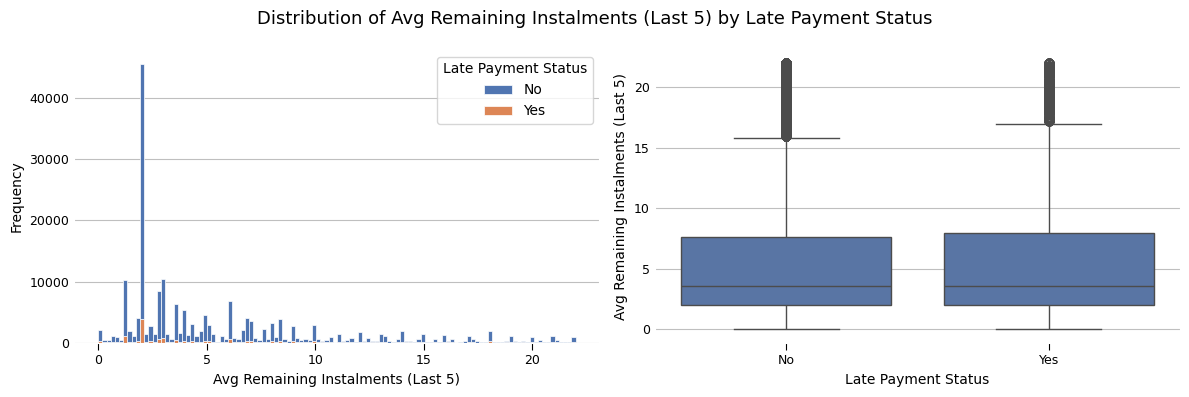

Medians for Avg Remaining Instalments (Last 5) by Late Payment Status:
No: 3.60
Yes: 3.60
Bootstrap hypothesis test p-value: 0.00


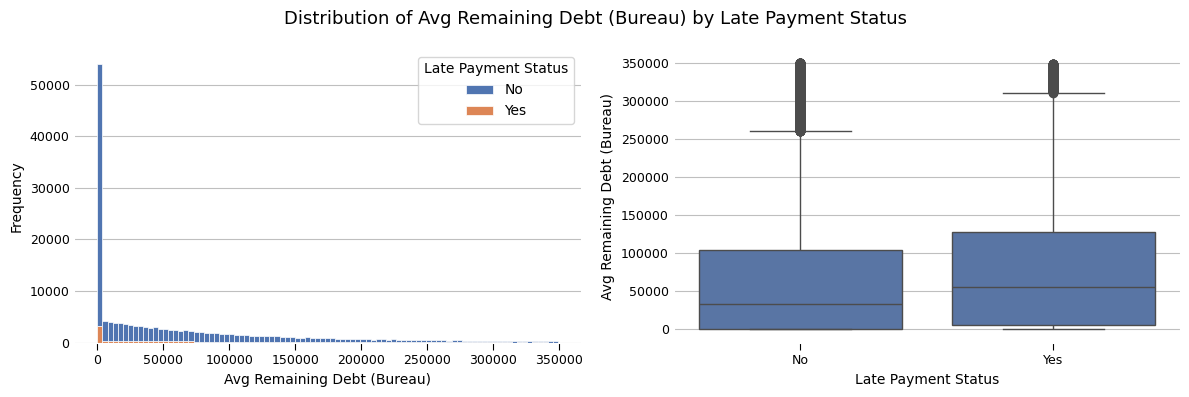

Medians for Avg Remaining Debt (Bureau) by Late Payment Status:
No: 32769.00
Yes: 55184.40
Bootstrap hypothesis test p-value: 0.00


In [23]:
numeric_columns = most_important_features.select_dtypes(include=["number"])
percentile = numeric_columns.quantile(0.9)
most_important_features_less_outliers = most_important_features.copy()
most_important_features_less_outliers.loc[
    most_important_features_less_outliers["Avg Remaining Debt (Bureau)"] < 0,
    "Avg Remaining Debt (Bureau)",
] = np.nan
most_important_features_less_outliers.loc[
    most_important_features_less_outliers["Days Employed"] > 300000,
    "Late Payment Status",
] = np.nan
for col in numeric_columns.columns:
    most_important_features_less_outliers[col] = most_important_features_less_outliers[
        col
    ].where(most_important_features_less_outliers[col] <= percentile[col], np.nan)
numeric_relationships(most_important_features_less_outliers, "Late Payment Status")

## Summray

While statistically significant differences were found across all associations due to the large dataset, they may not be meaningful because those differences are probably be too small.

Features with week assosiations with late repayments:

- Goods Price: More expensive goods baught show a very slight decrease in repayment likelihood, but the difference is negligible.
- Annuity: Higher annuities show only minimal differences in repayment likelihood.
- Number of Installments Left to Pay: Borrowers with more remaining installments do not differ in repayment behavior.
 
Features with stronger assosiations with late repayments:

- Late Payments: Individuals who were late on previous payments are more likely to be late again.
- Outstanding Debt from Previous Loans: Borrowers with unpaid debt are more likely to miss payments.
- Gender: Males are less likely to repay on time compared to females.
- Education: Less educated individuals are less likely to repay.
- External Risk Assessments: Those flagged as high-risk by external sources are significantly more likely to be late.
- Amount of Credit Granted: Borrowers taking out larger loans are slightly more likely to repay, though the difference is modest.

# Feature Engineering

The main objectives for this section of the notebook are:

- To develop features that have the potential to improve the model's performance.

Feature engineering will be approached in the following ways:

- Features likely to be important, based on my understanding of the topic, mainly focusing on monetary sums related to granting or repaying credit.
- Random guesses for potentially meaningful ratios.
- Using mean, min, max, and mode aggregations as baseline techniques to merge data with the main table.
- Aggregating the most recent entries, as recent data is often more relevant.
- Creating ratios based on the most important features identified through SHAP feature importance after building the model.
- Various other ideas are listed in the markdow.

The usefulness of these features will be evaluated during model training and refinement. Features will be dropped if they demonstrate low predictive value, as determined by the Phik correlation coefficient between the target variable and predictors, as well as SHAP feature importance during the machine learning stage.

## Application

Features based on data's context:

- DEBT_TO_INCOME_RATIO: Proportion of the client’s income committed to the loan.
- INCOME_STABILITY: Ratio of employment duration to age, where higher values might reflect a longer, stable employment history.
- INCOME_PER_FAMILY_MEMBER: Income available per family member.
- POPULATION_DENSITY_RISK: Combination of population density and region rating, potentially showing location-based risk.
- CREDIT_TO_ANNUITY_RATIO: Number of annuity payments required to pay off the loan, with higher values indicating longer payment periods.
- EMPLOYMENT_TO_REGISTRATION_RATIO: Ratio of employment duration to registration duration, where higher values may suggest lower mobility.
- ANNUITY_TO_INCOME_RATIO: Proportion of loan annuity to income, indicating the burden of loan payments relative to income.
- CHILDREN_PER_FAMILY_MEMBER: Ratio of children to total family members.

Additional feature engineering was done at the end of the project, based on SHAP values, focusing only on the most important predictors.

In [24]:
application["DEBT_TO_INCOME_RATIO"] = application["AMT_CREDIT"] / application[
    "AMT_INCOME_TOTAL"
].replace(0, np.nan)
application["INCOME_STABILITY"] = application["DAYS_EMPLOYED"].replace(
    {365243: np.nan}
) / application["DAYS_BIRTH"].replace(0, np.nan)
application["CREDIT_TERM_TO_AGE_RATIO"] = application["AMT_ANNUITY"] / application[
    "AMT_CREDIT"
].replace(0, np.nan)
application["INCOME_PER_FAMILY_MEMBER"] = application["AMT_INCOME_TOTAL"] / application[
    "CNT_FAM_MEMBERS"
].replace(0, np.nan)
application["POPULATION_DENSITY_RISK"] = application[
    "REGION_POPULATION_RELATIVE"
] * application["REGION_RATING_CLIENT"].replace(0, np.nan)
application["CREDIT_TO_ANNUITY_RATIO"] = application["AMT_CREDIT"] / application[
    "AMT_ANNUITY"
].replace(0, np.nan)
application["EMPLOYMENT_TO_REGISTRATION_RATIO"] = application["DAYS_EMPLOYED"].replace(
    {365243: np.nan}
) / application["DAYS_REGISTRATION"].replace(0, np.nan)
application["ANNUITY_TO_INCOME_RATIO"] = application["AMT_ANNUITY"] / application[
    "AMT_INCOME_TOTAL"
].replace(0, np.nan)
application["CHILDREN_PER_FAMILY_MEMBER"] = application["CNT_CHILDREN"] / application[
    "CNT_FAM_MEMBERS"
].replace(0, np.nan)

# Some ideas based on feature importance (SHAP):
application["DAYS_BIRTH_TO_ANNUITY_RATIO"] = application["DAYS_BIRTH"] / application[
    "AMT_ANNUITY"
].replace(0, np.nan)
application["DAYS_BIRTH_TO_CREDIT_RATIO"] = application["DAYS_BIRTH"] / application[
    "AMT_CREDIT"
].replace(0, np.nan)
application["DAYS_BIRTH_TO_INCOME_RATIO"] = application["DAYS_BIRTH"] / application[
    "AMT_INCOME_TOTAL"
].replace(0, np.nan)
application["DAYS_EMPLOYED_TO_ANNUITY_RATIO"] = application["DAYS_EMPLOYED"].replace(
    {365243: np.nan}
) / application["AMT_ANNUITY"].replace(0, np.nan)
application["DAYS_EMPLOYED_TO_CREDIT_RATIO"] = application["DAYS_EMPLOYED"].replace(
    {365243: np.nan}
) / application["AMT_CREDIT"].replace(0, np.nan)
application["DAYS_EMPLOYED_TO_INCOME_RATIO"] = application["DAYS_EMPLOYED"].replace(
    {365243: np.nan}
) / application["AMT_INCOME_TOTAL"].replace(0, np.nan)
application["DAYS_EMPLOYED_TO_GOODS_PRICE_RATIO"] = application[
    "DAYS_EMPLOYED"
].replace({365243: np.nan}) / application["AMT_GOODS_PRICE"].replace(0, np.nan)
application["ANNUITY_TO_GOODS_RATIO"] = application["AMT_ANNUITY"] / application[
    "AMT_GOODS_PRICE"
].replace(0, np.nan)
application["CAR_AGE_TO_AGE_RATIO"] = application["OWN_CAR_AGE"] / application[
    "DAYS_BIRTH"
].replace(0, np.nan)
application["CREDIT_TO_GOODS_RATIO"] = application["AMT_CREDIT"] / application[
    "AMT_GOODS_PRICE"
].replace(0, np.nan)
application["DAYS_BIRTH_TO_OWN_CAR_AGE"] = application["DAYS_BIRTH"] / application[
    "OWN_CAR_AGE"
].replace(0, np.nan)
application["GOODS_PRICE_TO_DAYS_BIRTH"] = application["AMT_GOODS_PRICE"] / application[
    "DAYS_BIRTH"
].replace(0, np.nan)
application["DAYS_REGISTRATION_TO_DAYS_ID_PUBLISH"] = application[
    "DAYS_REGISTRATION"
] / application["DAYS_ID_PUBLISH"].replace(0, np.nan)

### Correlation Between Predictors

To improve the interpretability of feature importance in the model, redundant information should be removed, retaining only one representative feature from each highly correlated group. After adding min, max, and mean aggregations, the number of correlated features grew too large, making the process too time-consuming. I chose to remove highly correlated features in the application table, accepting that some important information might be overlooked due to its influence being split across correlated variables.

To remove highly correlated features and assist with feature selection later, I will use the Phik ($\phi_K$) correlation coefficient. The phik correlation coefficient measures the strength of association between variables including nonlinear assosiations and it is also adapted for categorical data types (it converts numeric variables into categorical ones). Its values range from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. This measure does not indicate the direction of the influence.

After testing various Phik correlation thresholds and observing model performance, I found that dropping features with correlations above 0.99 yielded the best results. If this value is lovered, the model performance began to decline.


In [25]:
correlated_to_drop = [
    "FLAG_MOBIL",
    "NAME_INCOME_TYPE",
    "FLAG_EMP_PHONE",
    "ORGANIZATION_TYPE",
    "INCOME_STABILITY",
    "ENTRANCES_MEDI",
    "BASEMENTAREA_MEDI",
    "ELEVATORS_MEDI",
    "ENTRANCES_MODE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "NONLIVINGAPARTMENTS_MEDI",
    "LANDAREA_MEDI",
    "FLOORSMIN_MEDI",
    "NONLIVINGAPARTMENTS_MEDI",
    "COMMONAREA_MEDI",
    "FLOORSMAX_MEDI",
    "YEARS_BUILD_MEDI",
    "REGION_RATING_CLIENT_W_CITY",
    "APARTMENTS_MEDI",
    "NONLIVINGAPARTMENTS_MODE",
    "LIVINGAPARTMENTS_MEDI",
    "COMMONAREA_MODE",
    "FLOORSMIN_MODE",
    "LIVINGAREA_MEDI",
    "NONLIVINGAREA_MEDI",
    "YEARS_BUILD_MEDI",
    "YEARS_BEGINEXPLUATATION_MEDI",
    "FLOORSMAX_MODE",
    "LANDAREA_MODE",
    "BASEMENTAREA_MODE",
    "YEARS_BUILD_MODE",
    "APARTMENTS_MODE",
]
application.drop(columns=correlated_to_drop, inplace=True, errors="ignore")
phik_between_predictors(application)

ELEVATORS_AVG                  ELEVATORS_MODE                        0.988802
AMT_CREDIT                     AMT_GOODS_PRICE                       0.987619
LIVINGAREA_AVG                 LIVINGAREA_MODE                       0.984372
NONLIVINGAREA_AVG              NONLIVINGAREA_MODE                    0.980405
DAYS_EMPLOYED_TO_CREDIT_RATIO  DAYS_EMPLOYED_TO_GOODS_PRICE_RATIO    0.979574
dtype: float64

## Previous Application

This table is similar to the "application" table, and I designed features based on monetary information. The groupings and aggregations were tailored to account for the varying characteristics of different loan types. Simple mean, min, and max aggregations of the entire columns, without considering loan types, are also included in the final aggregated dataframe.

In [26]:
# Drop all columns with more than 95% missing values
previous_application = previous_application.loc[
    :, previous_application.isnull().mean() <= 0.95
]

# Based on ideas from "application":
previous_application["CREDIT_TO_APPLICATION_RATIO"] = previous_application[
    "AMT_CREDIT"
] / previous_application["AMT_APPLICATION"].replace(0, np.nan)
previous_application["DOWN_PAYMENT_TO_CREDIT_RATIO"] = previous_application[
    "AMT_DOWN_PAYMENT"
] / previous_application["AMT_CREDIT"].replace(0, np.nan)
previous_application["ANNUITY_TO_CREDIT_RATIO"] = previous_application[
    "AMT_ANNUITY"
] / previous_application["AMT_CREDIT"].replace(0, np.nan)
previous_application["GOODS_PRICE_TO_CREDIT_RATIO"] = previous_application[
    "AMT_GOODS_PRICE"
] / previous_application["AMT_CREDIT"].replace(0, np.nan)
previous_application["PAYMENT_TO_GOODS_PRICE_RATIO"] = previous_application[
    "AMT_ANNUITY"
] / previous_application["AMT_GOODS_PRICE"].replace(0, np.nan)
previous_application["DOWN_PAYMENT_TO_GOODS_PRICE_RATIO"] = previous_application[
    "AMT_DOWN_PAYMENT"
] / previous_application["AMT_GOODS_PRICE"].replace(0, np.nan)
previous_application["DECISION_TO_FIRST_DUE_RATIO"] = previous_application[
    "DAYS_DECISION"
] / previous_application["DAYS_FIRST_DUE"].replace(0, np.nan)
previous_application["FIRST_DRAWING_TO_TERMINATION_RATIO"] = previous_application[
    "DAYS_FIRST_DRAWING"
] / previous_application["DAYS_TERMINATION"].replace(0, np.nan)
previous_application["FIRST_DUE_TO_LAST_DUE_RATIO"] = previous_application[
    "DAYS_FIRST_DUE"
] / previous_application["DAYS_LAST_DUE"].replace(0, np.nan)
previous_application["INSTALLMENTS_TO_CREDIT_RATIO"] = previous_application[
    "CNT_PAYMENT"
] / previous_application["AMT_CREDIT"].replace(0, np.nan)

# Random guesses:
previous_application["APPLICATION_TO_GOODS_PRICE_RATIO"] = previous_application[
    "AMT_APPLICATION"
] / previous_application["AMT_GOODS_PRICE"].replace(0, np.nan)
previous_application["DOWN_PAYMENT_TO_APPLICATION_RATIO"] = previous_application[
    "AMT_DOWN_PAYMENT"
] / previous_application["AMT_APPLICATION"].replace(0, np.nan)
previous_application["DECISION_TO_TERMINATION_RATIO"] = previous_application[
    "DAYS_DECISION"
] / previous_application["DAYS_TERMINATION"].replace(0, np.nan)
previous_application["GOODS_PRICE_TO_DOWN_PAYMENT_RATIO"] = previous_application[
    "AMT_GOODS_PRICE"
] / previous_application["AMT_DOWN_PAYMENT"].replace(0, np.nan)
previous_application["FIRST_DRAWING_TO_FIRST_DUE_RATIO"] = previous_application[
    "DAYS_FIRST_DRAWING"
] / previous_application["DAYS_FIRST_DUE"].replace(0, np.nan)
previous_application["TERMINATION_TO_LAST_DUE_RATIO"] = previous_application[
    "DAYS_TERMINATION"
] / previous_application["DAYS_LAST_DUE"].replace(0, np.nan)
previous_application["APPLICATION_TO_ANNUITY_RATIO"] = previous_application[
    "AMT_APPLICATION"
] / previous_application["AMT_ANNUITY"].replace(0, np.nan)
previous_application["GOODS_PRICE_TO_CREDIT_TERM_RATIO"] = previous_application[
    "AMT_GOODS_PRICE"
] / previous_application["CNT_PAYMENT"].replace(0, np.nan)

# Groupings-aggregations based on contract type.
previous_application["NAME_CONTRACT_TYPE"] = previous_application[
    "NAME_CONTRACT_TYPE"
].replace(
    {
        "Consumer loans": "Consumer_loans",
        "Cash loans": "Cash_loans",
        "Revolving loans": "Revolving_loans",
    }
)
numerical_columns = previous_application.select_dtypes(include=["number"]).columns
agg_dict = {col: ["mean"] for col in numerical_columns}
agg_dict["SK_ID_PREV"] = "count"
previous_application_split_aggregated = (
    previous_application.groupby(["SK_ID_CURR", "NAME_CONTRACT_TYPE"], observed=True)
    .agg(agg_dict)
    .reset_index()
)
previous_application_split_aggregated.columns = [
    "_".join(col).strip("_").upper() if isinstance(col, tuple) else col.upper()
    for col in previous_application_split_aggregated.columns
]
previous_application_aggregated = previous_application_split_aggregated.pivot(
    index="SK_ID_CURR", columns="NAME_CONTRACT_TYPE"
).reset_index()
previous_application_aggregated.columns = [
    "_".join(col).strip("_").upper() if isinstance(col, tuple) else col.upper()
    for col in previous_application_aggregated.columns
]
previous_application_aggregated.drop(
    columns=[
        "SK_ID_CURR_MEAN_CASH_LOANS",
        "SK_ID_CURR_MEAN_CONSUMER_LOANS",
        "SK_ID_CURR_MEAN_REVOLVING_LOANS",
    ],
    inplace=True,
    errors="ignore",
)

# General groupings-aggregations
previous_application_all_aggregated = min_max_mean_mode_aggregation(
    previous_application, "SK_ID_CURR", ["SK_ID_PREV"]
)
previous_application_aggregated = previous_application_aggregated.merge(
    previous_application_all_aggregated, on="SK_ID_CURR", how="left"
)

# Drop all columns with more than 95% missing values
previous_application_aggregated = previous_application_aggregated.loc[
    :, previous_application_aggregated.isnull().mean() <= 0.95
]

### Bureau and Bureau Balance

Bureau Balance has only one feature with useful information, and simple aggregations such as mean, max are not helpful.

- MAX_STATUS: Indicates worst status for each credit, signaling highest risk level. Currently, this feature does not distinguish between cases where all payment information is unknown ("X") and cases where all recorded statuses are "C" (fully paid). Both situations can result in NaN.
- CONSECUTIVE_ZEROS_BEFORE_C: Count of timely payments before credit closure, suggesting stability.
- LAST_STATUS_AT_MOST_RECENT_MONTH: Final recorded status, showing if the credit was repaid.
- PROPORTION_OF_EACH_STATUS: Shows payment patterns of delays or regular payments.

For the Bureau data, I plan to create ratio features related to credit amounts and repayments without conducting a deeper analysis of this information.

In [27]:
status_counts = bureau_balance.pivot_table(
    index="SK_ID_BUREAU", columns="STATUS", aggfunc="size", fill_value=0
)
status_proportions = status_counts.div(status_counts.sum(axis=1), axis=0)
bureau_balance["STATUS_num"] = pd.to_numeric(bureau_balance["STATUS"], errors="coerce")
max_status = bureau_balance.groupby("SK_ID_BUREAU")["STATUS_num"].max()
status_proportions = status_proportions.reset_index()
status_proportions.columns.name = None
status_proportions = status_proportions.set_index("SK_ID_BUREAU")


def count_consecutive_zeros_before_c(status_series: pd.Series) -> int:
    """Count consecutive '0' values in a series until the first occurrence of 'C'."""
    count = 0
    for status in status_series:
        if status == "C":
            break
        elif status == "0":
            count += 1
        else:
            count = 0
    return count


consecutive_zeros = bureau_balance.groupby("SK_ID_BUREAU")["STATUS"].apply(
    count_consecutive_zeros_before_c
)
last_status = bureau_balance[bureau_balance["MONTHS_BALANCE"] == 0].set_index(
    "SK_ID_BUREAU"
)["STATUS"]
sorted_bureau_balance = bureau_balance.sort_values(
    ["SK_ID_BUREAU", "MONTHS_BALANCE"], ascending=[True, False]
)
recent_bureau_balance = sorted_bureau_balance.groupby("SK_ID_BUREAU").head(5)
mode_bureau_balance = recent_bureau_balance.groupby("SK_ID_BUREAU")["STATUS"].apply(
    lambda x: x.mode()[0]
)
bureau_balance_aggregated = (
    pd.DataFrame(
        {
            "MAX_STATUS": max_status,
            "CONSECUTIVE_ZEROS_BEFORE_C": consecutive_zeros,
            "LAST_STATUS_AT_MOST_RECENT_MONTH": last_status,
            "RECENT_STATUS_MODE": mode_bureau_balance,
        }
    )
    .join(status_proportions, how="left")
    .reset_index()
)
bureau_balance_aggregated.rename(
    columns={
        "0": "ZERO",
        "1": "ONE",
        "2": "TWO",
        "3": "THREE",
        "4": "FOUR",
        "5": "FIVE",
    },
    inplace=True,
)

# Random guesses related to monetary values
bureau["CREDIT_DEBT_RATIO"] = bureau["AMT_CREDIT_SUM_DEBT"] / bureau[
    "AMT_CREDIT_SUM"
].replace(0, np.nan)
bureau["CREDIT_OVERDUE_RATIO"] = bureau["AMT_CREDIT_SUM_OVERDUE"] / bureau[
    "AMT_CREDIT_SUM"
].replace(0, np.nan)
bureau["CREDIT_LIMIT_RATIO"] = bureau["AMT_CREDIT_SUM_LIMIT"] / bureau[
    "AMT_CREDIT_SUM"
].replace(0, np.nan)
bureau["MAX_OVERDUE_TO_CREDIT_RATIO"] = bureau["AMT_CREDIT_MAX_OVERDUE"] / bureau[
    "AMT_CREDIT_SUM"
].replace(0, np.nan)
bureau["PROLONG_TO_CREDIT_RATIO"] = bureau["CNT_CREDIT_PROLONG"] / bureau[
    "AMT_CREDIT_SUM"
].replace(0, np.nan)
bureau["OVERDUE_DAYS_RATIO"] = bureau["CREDIT_DAY_OVERDUE"] / bureau[
    "DAYS_CREDIT"
].replace(0, np.nan)
bureau["CREDIT_DURATION_RATIO"] = bureau["DAYS_CREDIT_ENDDATE"] / bureau[
    "DAYS_CREDIT"
].replace(0, np.nan)
bureau["DAYS_END_TO_DURATION_RATIO"] = bureau["DAYS_ENDDATE_FACT"] / bureau[
    "DAYS_CREDIT"
].replace(0, np.nan)
bureau["CREDIT_ANN_DEBT_RATIO"] = bureau["AMT_ANNUITY"] / bureau[
    "AMT_CREDIT_SUM_DEBT"
].replace(0, np.nan)
bureau["CREDIT_UPDATE_DURATION_RATIO"] = bureau["DAYS_CREDIT_UPDATE"] / bureau[
    "DAYS_CREDIT"
].replace(0, np.nan)
bureau["ANNUITY_TO_CREDIT_RATIO"] = bureau["AMT_ANNUITY"] / bureau[
    "AMT_CREDIT_SUM"
].replace(0, np.nan)

bureau_merged = bureau.merge(bureau_balance_aggregated, on="SK_ID_BUREAU", how="left")
bureau_merged = bureau_merged.drop(columns="SK_ID_BUREAU")
bureau_merged_aggregated = min_max_mean_mode_aggregation(
    bureau_merged, "SK_ID_CURR", ["CREDIT_CURRENCY"]
)

## Installments Payments

The table would not benefit from simple aggregations like the mean of each feature, as the key information lies in the differences between the expected and actual payments made by the borrower. I will apply the same engineering process to the first few (5) installments and all installments made by the borrower.

- TOTAL_NUM_INSTALLMENTS: Total count of installments for previous loans. Longer loans are riskier than shorter loans.
- TOTAL_LATE_PAYMENTS and LATE_PAYMENT_RATIO: Total count and proportion of late payments, indicating the number of instances where the client was delayed in paying an installment.
- MEAN_DAYS_LATE and MEAN_NORMALIZED_DAYS_LATE: Average number of days the client was late in paying installments.
- MEAN_AMOUNT_DIFFERENCE and MEAN_NORMALIZED_AMOUNT_DIFFERENCE: Average difference between the paid amount and the expected installment amount. Negative values suggest consistent underpayment.
- LATE_PAYMENTS_FIRST_5: Count of late payments in the first five installments. When a loan applicant is late once, they might continue to be late.
- NUM_INSTALMENT_VERSIONS: Count of unique installment versions.

In [ ]:
installments_payments_raw = pd.read_csv("installments_payments.csv")
installments_payments = installments_payments_raw[
    installments_payments_raw["SK_ID_CURR"].isin(train_validation_id_curr)
].copy()
installments_payments_reworked = pd.DataFrame(
    {
        "SK_ID_CURR": installments_payments["SK_ID_CURR"],
        "NUM_INSTALMENT_NUMBER": installments_payments["NUM_INSTALMENT_NUMBER"],
        "DAYS_LATE": installments_payments["DAYS_ENTRY_PAYMENT"]
        - installments_payments["DAYS_INSTALMENT"],
        "NORMALIZED_DAYS_LATE": (
            installments_payments["DAYS_ENTRY_PAYMENT"]
            - installments_payments["DAYS_INSTALMENT"]
        )
        / installments_payments["DAYS_INSTALMENT"].replace(0, np.nan),
        "AMOUNT_DIFFERENCE": installments_payments["AMT_PAYMENT"]
        - installments_payments["AMT_INSTALMENT"],
        "NORMALIZED_AMOUNT_DIFFERENCE": (
            installments_payments["AMT_PAYMENT"]
            - installments_payments["AMT_INSTALMENT"]
        )
        / installments_payments["AMT_INSTALMENT"].replace(0, np.nan),
        "LATE_PAYMENT": (
            installments_payments["DAYS_ENTRY_PAYMENT"]
            > installments_payments["DAYS_INSTALMENT"]
        ).astype(int),
    }
)
installments_payments_aggregated = installments_payments_reworked.groupby(
    "SK_ID_CURR"
).agg(
    TOTAL_NUM_INSTALLMENTS=("DAYS_LATE", "count"),
    TOTAL_LATE_PAYMENTS=("LATE_PAYMENT", "sum"),
    LATE_PAYMENT_RATIO=("LATE_PAYMENT", lambda x: x.sum() / x.count()),
    MEAN_DAYS_LATE=("DAYS_LATE", "mean"),
    MEAN_NORMALIZED_DAYS_LATE=("NORMALIZED_DAYS_LATE", "mean"),
    MEAN_AMOUNT_DIFFERENCE=("AMOUNT_DIFFERENCE", "mean"),
    MEAN_NORMALIZED_AMOUNT_DIFFERENCE=("NORMALIZED_AMOUNT_DIFFERENCE", "mean"),
)

installments_payments_reworked_sorted = installments_payments_reworked.sort_values(
    by=["SK_ID_CURR", "NUM_INSTALMENT_NUMBER"]
)
first_five_installments = installments_payments_reworked_sorted.groupby(
    "SK_ID_CURR"
).head(5)
late_in_first_five = (
    first_five_installments.groupby("SK_ID_CURR")["LATE_PAYMENT"].sum().reset_index()
)
late_in_first_five.columns = ["SK_ID_CURR", "LATE_PAYMENTS_FIRST_5"]
installments_payments_aggregated = installments_payments_aggregated.merge(
    late_in_first_five, on="SK_ID_CURR", how="left"
)

version_counts = (
    installments_payments.groupby("SK_ID_CURR")["NUM_INSTALMENT_VERSION"]
    .nunique()
    .reset_index()
)
version_counts.columns = ["SK_ID_CURR", "NUM_INSTALMENT_VERSIONS"]
installments_payments_aggregated = installments_payments_aggregated.merge(
    version_counts, on="SK_ID_CURR", how="left"
)

## POS CASH Balance, Credit Card

I spend least amount of time exploring these tables and instead focused on guessing some potentially useful ratio features. Additionally, I aggregated the information for the most recent entries.

In [ ]:
pos_cash_balance["INSTALMENTS_COMPLETION_RATIO"] = (
    pos_cash_balance["CNT_INSTALMENT"] - pos_cash_balance["CNT_INSTALMENT_FUTURE"]
) / pos_cash_balance["CNT_INSTALMENT"].replace(0, np.nan)
pos_cash_balance["DPD_TO_REMAINING_INSTALMENTS_RATIO"] = pos_cash_balance[
    "SK_DPD"
] / pos_cash_balance["CNT_INSTALMENT_FUTURE"].replace(0, np.nan)
pos_cash_balance["DPD_DEF_TO_DPD_RATIO"] = pos_cash_balance[
    "SK_DPD_DEF"
] / pos_cash_balance["SK_DPD"].replace(0, np.nan)
pos_cash_balance["AVG_DPD_PER_INSTALMENT"] = pos_cash_balance[
    "SK_DPD"
] / pos_cash_balance["CNT_INSTALMENT_FUTURE"].replace(0, np.nan)
pos_cash_balance["AVG_DPD_DEF_PER_INSTALMENT"] = pos_cash_balance[
    "SK_DPD_DEF"
] / pos_cash_balance["CNT_INSTALMENT_FUTURE"].replace(0, np.nan)
pos_cash_balance["MONTHLY_DELAY_RATIO"] = pos_cash_balance["SK_DPD"] / pos_cash_balance[
    "MONTHS_BALANCE"
].replace(0, np.nan)
pos_cash_balance["ON_TIME_INSTALMENTS_RATIO"] = (
    pos_cash_balance["CNT_INSTALMENT"] - pos_cash_balance["SK_DPD_DEF"]
) / pos_cash_balance["CNT_INSTALMENT"].replace(0, np.nan)

pos_cash_balance = pos_cash_balance.drop(columns="SK_ID_PREV", errors="ignore")
all_time_pos_cash_balance_aggregated = min_max_mean_mode_aggregation(
    pos_cash_balance, "SK_ID_CURR"
)
recent_pos_cash_balance_aggregated = mean_aggregation_of_recent(
    pos_cash_balance, "SK_ID_CURR", "MONTHS_BALANCE", 5
)
pos_cash_balance_aggregated = all_time_pos_cash_balance_aggregated.merge(
    recent_pos_cash_balance_aggregated, on="SK_ID_CURR", how="left"
)
pos_cash_balance_aggregated = pos_cash_balance_aggregated.drop(
    columns=["MONTHS_BALANCE_MIN", "MONTHS_BALANCE_MEAN"]
)

credit_card_balance_raw = pd.read_csv("credit_card_balance.csv")
credit_card_balance = credit_card_balance_raw[
    credit_card_balance_raw["SK_ID_CURR"].isin(train_validation_id_curr)
].copy()
credit_card_balance = credit_card_balance.drop(columns="SK_ID_PREV")
credit_card_balance["BALANCE_TO_CREDIT_LIMIT_RATIO"] = credit_card_balance[
    "AMT_BALANCE"
] / credit_card_balance["AMT_CREDIT_LIMIT_ACTUAL"].replace(0, np.nan)
credit_card_balance["ATM_DRAWINGS_TO_TOTAL_DRAWINGS_RATIO"] = credit_card_balance[
    "AMT_DRAWINGS_ATM_CURRENT"
] / credit_card_balance["AMT_DRAWINGS_CURRENT"].replace(0, np.nan)
credit_card_balance["OTHER_DRAWINGS_TO_TOTAL_DRAWINGS_RATIO"] = credit_card_balance[
    "AMT_DRAWINGS_OTHER_CURRENT"
] / credit_card_balance["AMT_DRAWINGS_CURRENT"].replace(0, np.nan)
credit_card_balance["POS_DRAWINGS_TO_TOTAL_DRAWINGS_RATIO"] = credit_card_balance[
    "AMT_DRAWINGS_POS_CURRENT"
] / credit_card_balance["AMT_DRAWINGS_CURRENT"].replace(0, np.nan)
credit_card_balance["MIN_INSTALLMENT_TO_TOTAL_PAYMENT_RATIO"] = credit_card_balance[
    "AMT_INST_MIN_REGULARITY"
] / credit_card_balance["AMT_PAYMENT_TOTAL_CURRENT"].replace(0, np.nan)
credit_card_balance["PAYMENT_TO_RECEIVABLE_RATIO"] = credit_card_balance[
    "AMT_PAYMENT_CURRENT"
] / credit_card_balance["AMT_RECIVABLE"].replace(0, np.nan)
credit_card_balance["PAYMENT_TOTAL_TO_TOTAL_RECEIVABLE_RATIO"] = credit_card_balance[
    "AMT_PAYMENT_TOTAL_CURRENT"
] / credit_card_balance["AMT_TOTAL_RECEIVABLE"].replace(0, np.nan)
credit_card_balance["RECEIVABLE_TO_CREDIT_LIMIT_RATIO"] = credit_card_balance[
    "AMT_RECEIVABLE_PRINCIPAL"
] / credit_card_balance["AMT_CREDIT_LIMIT_ACTUAL"].replace(0, np.nan)
credit_card_balance["TOTAL_RECEIVABLE_TO_CREDIT_LIMIT_RATIO"] = credit_card_balance[
    "AMT_TOTAL_RECEIVABLE"
] / credit_card_balance["AMT_CREDIT_LIMIT_ACTUAL"].replace(0, np.nan)
credit_card_balance["ATM_DRAWINGS_COUNT_RATIO"] = credit_card_balance[
    "CNT_DRAWINGS_ATM_CURRENT"
] / credit_card_balance["CNT_DRAWINGS_CURRENT"].replace(0, np.nan)
credit_card_balance["POS_DRAWINGS_COUNT_RATIO"] = credit_card_balance[
    "CNT_DRAWINGS_POS_CURRENT"
] / credit_card_balance["CNT_DRAWINGS_CURRENT"].replace(0, np.nan)
credit_card_balance["DAYS_PAST_DUE_RATIO"] = credit_card_balance[
    "SK_DPD"
] / credit_card_balance["MONTHS_BALANCE"].replace(0, np.nan)
credit_card_balance["DAYS_PAST_DUE_DEF_RATIO"] = credit_card_balance[
    "SK_DPD_DEF"
] / credit_card_balance["MONTHS_BALANCE"].replace(0, np.nan)

all_time_credit_card_balance_aggregated = min_max_mean_mode_aggregation(
    credit_card_balance, "SK_ID_CURR", ["NAME_CONTRACT_STATUS"]
)
recent_credit_card_balance_aggregated = mean_aggregation_of_recent(
    credit_card_balance, "SK_ID_CURR", "MONTHS_BALANCE", 5
)
credit_card_balance_aggregated = all_time_credit_card_balance_aggregated.merge(
    recent_credit_card_balance_aggregated, on="SK_ID_CURR", how="left"
)
credit_card_balance_aggregated = credit_card_balance_aggregated.rename(
    columns={
        col: f"CARD_{col}"
        for col in credit_card_balance_aggregated.columns
        if col != "SK_ID_CURR"
    }
)
credit_card_balance_aggregated.drop(
    columns=["CARD_SK_DPD_MIN", "CARD_SK_DPD_DEF_MIN"], inplace=True
)

# Machine Learning

The main objectives for this part of the notebook are:

- Test different models and preprocessing steps to find the one that performs the best.
- Refine the selected model to reduce overfitting and predict the test dataset.

ROC-AUC will be the primary metric for model evaluation.

Overall plan for training the best-performing model:

1) Hyperparameters will be tuned, and the least important features will be iteratively removed based on SHAP values. This iterative approach helps save time by avoiding the need to test a wide range of hyperparameters and run a large number of iterations.
2) Running this with all features would still take a lot of time, so I will first remove features least related to the target based on the Phik correlation coefficient, as long as it doesn't degrade model performance.

## Initial Model Evaluations

The overall goal of this subsection is to select the model (algorithm), determine feature preprocessing steps such as imputation and encoding, and remove features with the weakest connection to the target to improve training speed duirng hyperparameter tuning. This will be done on the application table, as it has the most predictive power and actions with it will have the largest impact. Throught the project I will use cross validation. Class balancing will be handled using weights, as other methods are unlikely to provide better results.

Below is the Phik correlation plot between the target and predictors. These values will be used during feature selection in the second part of this sebsection.

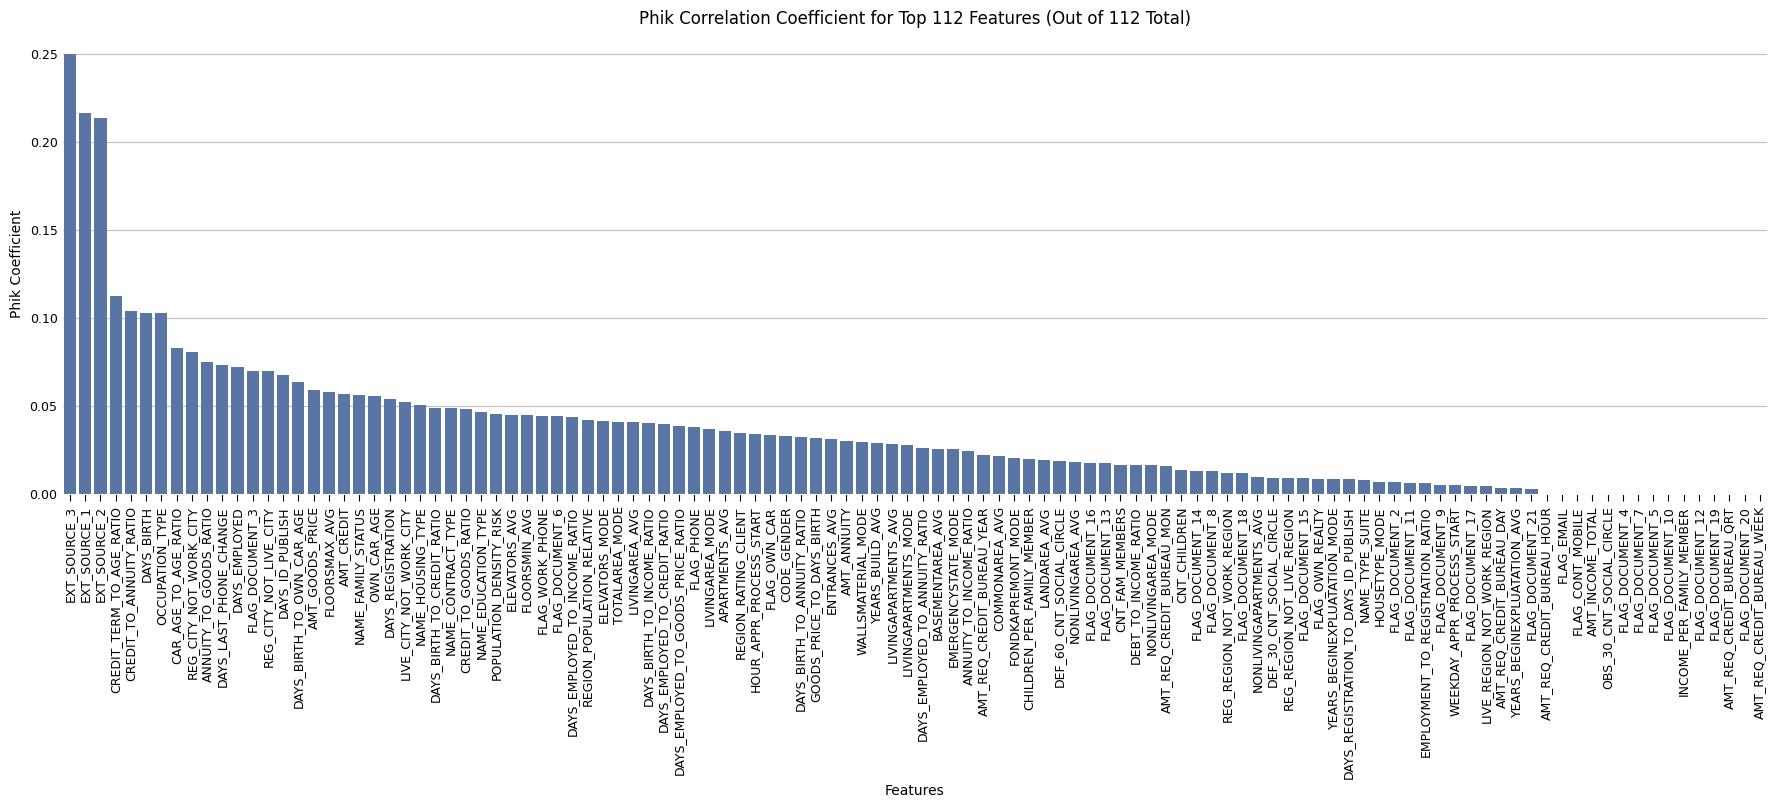

In [30]:
application_analyser = MachineLearning(application, "TARGET", ["SK_ID_CURR"])

### Selecting Algorithm and Preprocesing

I will be selecting from tree-based algorithms, primarily gradient boosting machines, as they are very likely to deliver the best performance apart from neural networks. For imputation, I will test both no imputation and median imputation for numeric variables. For encoding, I will explore one-hot encoding and target encoding. Logistic regression is included as an initial baseline reference. I have also attempted implementing KNN imputation in a few different ways, but it was taking too much time.

In [31]:
median_imputer = SimpleImputer(strategy="median")
target_encoding = TargetEncoder()
models = {
    "LogisticRegression": LogisticRegression,
    "RandomForest": RandomForestClassifier,
    "XGBoost": XGBClassifier,
    "CatBoost": CatBoostClassifier,
    "LightGBM": LGBMClassifier,
}
application_analyser.evaluate_models(0, models, median_imputer, target_encoding)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
LogisticRegression,0.746759,0.749615,0.677951,0.255911,0.157294,0.686017
RandomForest,0.725293,1.000000,0.919309,0.010279,0.519663,0.005192
XGBoost,0.749071,0.879565,0.745396,0.278088,0.180323,0.607421
CatBoost,0.757025,0.893852,0.757254,0.286466,0.187797,0.603616
LightGBM,0.764485,0.807610,0.712905,0.275062,0.172743,0.674694


Out of 112 original predictors, 112 were used.


In [32]:
one_hot_encoding = OneHotEncoder(handle_unknown="ignore")
models = {
    "RandomForest": RandomForestClassifier,
    "XGBoost": XGBClassifier,
    "CatBoost": CatBoostClassifier,
    "LightGBM": LGBMClassifier,
}
application_analyser.evaluate_models(0, models, median_imputer, one_hot_encoding)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
RandomForest,0.724013,1.000000,0.919258,0.006313,0.496645,0.003178
XGBoost,0.748744,0.879013,0.744810,0.277840,0.180055,0.608093
CatBoost,0.756633,0.894484,0.756156,0.283878,0.186049,0.598693
LightGBM,0.763859,0.807169,0.711836,0.274610,0.172323,0.675678


Out of 112 original predictors, 112 were used.


In [33]:
no_imputation = "passthrough"
models = {
    "XGBoost": XGBClassifier,
    "CatBoost": CatBoostClassifier,
    "LightGBM": LGBMClassifier,
}
application_analyser.evaluate_models(0, models, no_imputation, target_encoding)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
XGBoost,0.747981,0.881008,0.745100,0.276055,0.179087,0.602050
CatBoost,0.758325,0.893399,0.756348,0.286558,0.187637,0.606123
LightGBM,0.764488,0.809404,0.713838,0.275777,0.173294,0.674917


Out of 112 original predictors, 112 were used.


Based on ROC-AUC, LightGBM is the best-performing model. Different imputation and encoding methods gave very similar results, but target encoding without imputation was the fastest.

### Feature Selection

The goal is to remove features that do not significantly impact model performance. This will be done by selecting different Phik correlation coefficient thresholds and observing the resulting model performance. Running the model with multiple incremental thresholds would take longer, so I am adjusting the thresholds manually.

In [34]:
application_analyser.evaluate_models(0, models, no_imputation, target_encoding)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
XGBoost,0.747981,0.881008,0.745100,0.276055,0.179087,0.602050
CatBoost,0.758325,0.893399,0.756348,0.286558,0.187637,0.606123
LightGBM,0.764488,0.809404,0.713838,0.275777,0.173294,0.674917


Out of 112 original predictors, 112 were used.


In [35]:
models = {"LightGBM": LGBMClassifier}
application_analyser.evaluate_models(
    0.01, models, no_imputation, target_encoding
)  # best option
application_selected_features = application_analyser.return_selected_features(0.01)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
LightGBM,0.764815,0.808287,0.713451,0.275522,0.173089,0.674962


Out of 112 original predictors, 78 were used.


In [36]:
application_analyser.evaluate_models(0.02, models, no_imputation, target_encoding)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
LightGBM,0.76396,0.807421,0.712689,0.274724,0.172519,0.674067


Out of 112 original predictors, 64 were used.


In [37]:
application_analyser.evaluate_models(0.03, models, no_imputation, target_encoding)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
LightGBM,0.764204,0.80619,0.713126,0.274926,0.172702,0.673709


Out of 112 original predictors, 52 were used.


Determining a precise threshold is challenging due to variability caused by changes in the model's states and there is only an approximate score each time. However, it seems that features with a Phik correlation coefficient below 0.01 can be safely dropped without significantly affecting performance.

## Model Evaluation with Full Feature Set

This time I will train the model with all features and drop the ones that are unlikely to contribute significantly to the model's predictiveness.

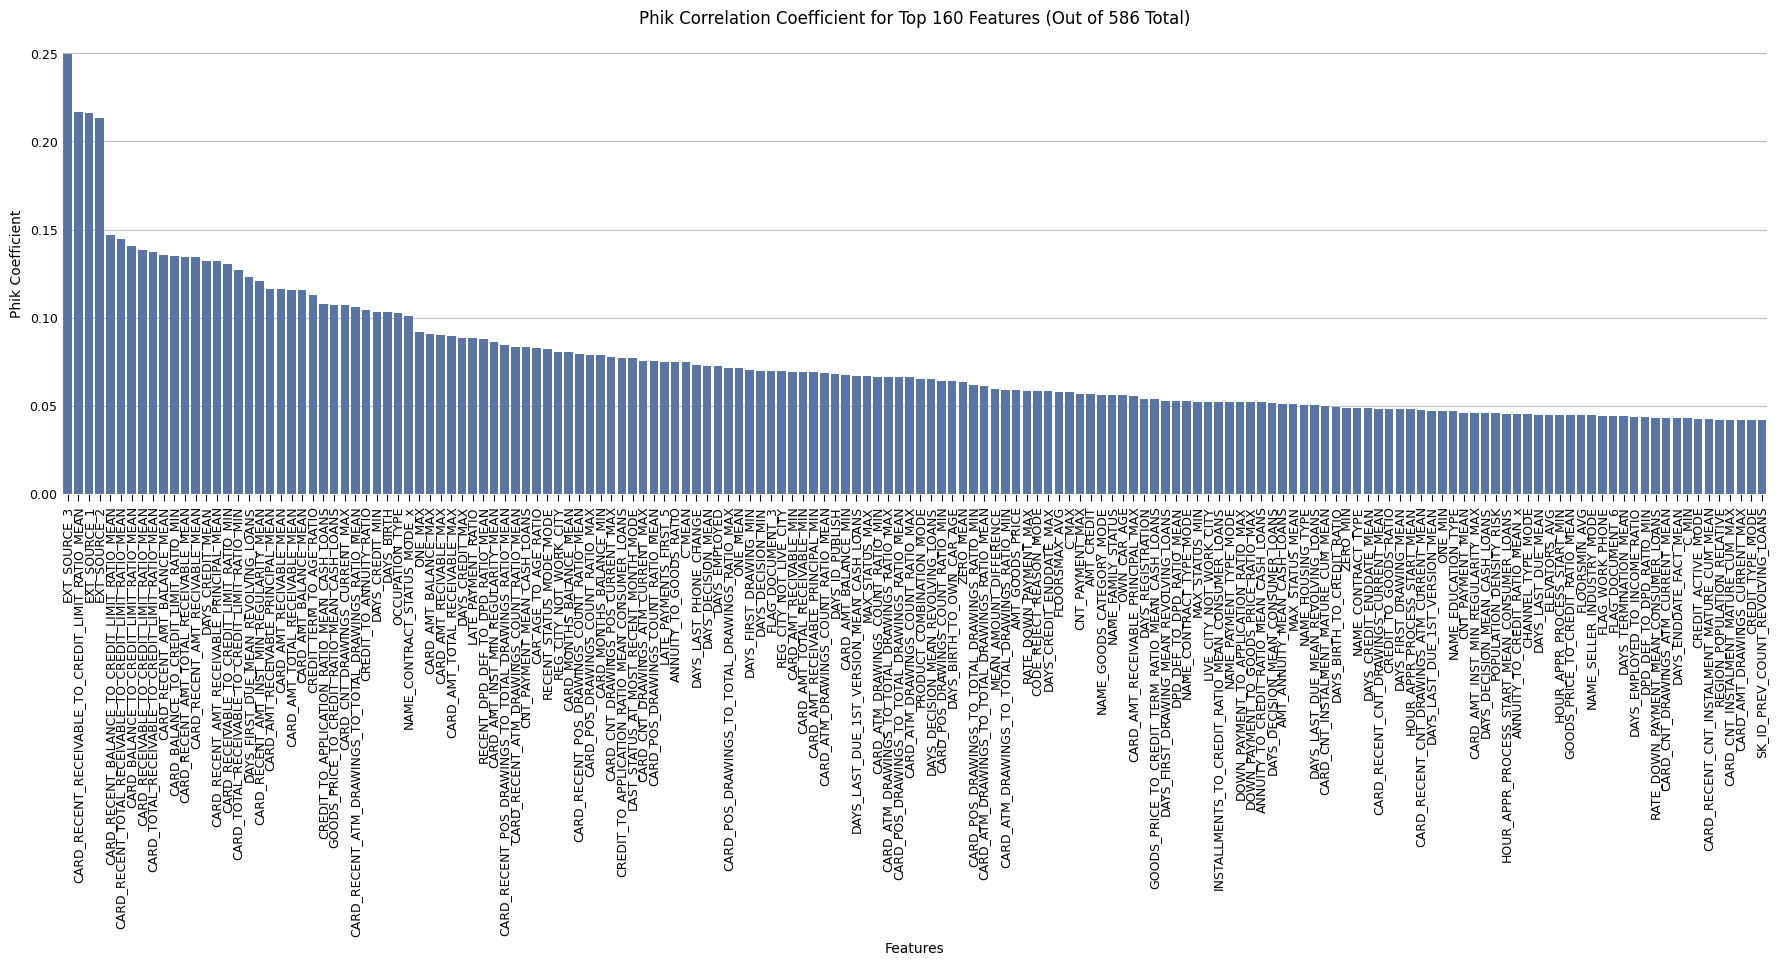

In [38]:
warnings.filterwarnings("ignore", message="Not enough unique value for variable")
loans = application_selected_features.merge(
    previous_application_aggregated, on="SK_ID_CURR", how="left"
)
loans = loans.merge(bureau_merged_aggregated, on="SK_ID_CURR", how="left")
loans = loans.merge(pos_cash_balance_aggregated, on="SK_ID_CURR", how="left")
loans = loans.merge(installments_payments_aggregated, on="SK_ID_CURR", how="left")
loans = loans.merge(credit_card_balance_aggregated, on="SK_ID_CURR", how="left")
loans_analyzer = MachineLearning(loans, "TARGET", ["SK_ID_CURR"])

In [39]:
loans_analyzer.evaluate_models(0, models, no_imputation, target_encoding)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
LightGBM,0.786629,0.839787,0.735037,0.295441,0.188097,0.688166


Out of 586 original predictors, 586 were used.


In [40]:
loans_analyzer.evaluate_models(
    0.0001, models, no_imputation, target_encoding
)  # best option
loans_selected_features = loans_analyzer.return_selected_features(0.0001)
loans_selected_features = loans_selected_features.drop(columns="SK_ID_CURR")

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
LightGBM,0.784635,0.837166,0.733104,0.294685,0.1873,0.690672


Out of 586 original predictors, 483 were used.


In [41]:
loans_analyzer.evaluate_models(0.005, models, no_imputation, target_encoding)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
LightGBM,0.783911,0.836857,0.733187,0.294107,0.186991,0.688524


Out of 586 original predictors, 452 were used.


In [42]:
loans_analyzer.evaluate_models(0.008, models, no_imputation, target_encoding)

,roc_auc,train_roc_auc,accuracy,f1,precision,recall
LightGBM,0.784033,0.836224,0.732569,0.29422,0.186938,0.690493


Out of 586 original predictors, 413 were used.


The model with all features performs the best, but retaining all information significantly increases the time required for tuning. Many of these features would likely be dropped as unimportant during repeated hyperparameter tunings anyway. Therefore, I will drop features with a Phik correlation coefficient below 0.0001.

## Model Tuning

I tuned hyperparameters using a Bayesian optimization strategy multiple times, dropping batches of 5-50 features in each iteration, with the initial batches being the largest. To declutter the notebook, I moved these lists into a module with functions. In the end, I settled on what I believe is close to the maximum validation score with the available input information. The final tuning session took around 3.5 hours with 20 iterations.

In [43]:
duplicate_rows = (
    loans_selected_features.drop(columns=unimportant_features, errors="ignore")
    .duplicated()
    .any()
)
print(f"Duplicated rows in the dataset: {duplicate_rows}\n")
X = loans_selected_features.drop(
    columns=["TARGET"] + unimportant_features, errors="ignore"
)
y = loans_selected_features["TARGET"]
y_encoded = LabelEncoder().fit_transform(y)
print(f"Features in the model: {X.shape[1]}\n")


def objective(trial: optuna.trial.Trial) -> float:
    """Optimize the LightGBM hyperparameters using Bayesian optimization with Optuna."""
    param = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 45),
        "max_depth": trial.suggest_int("max_depth", 8, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.08, log=True),
        "min_child_samples": trial.suggest_int("min_child_samples", 320, 700),
        "n_estimators": trial.suggest_int("n_estimators", 900, 1900),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }
    model = LGBMClassifier(
        **param, objective="binary", class_weight="balanced", random_state=5, verbose=0
    )
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor_tree_based),
            ("classifier", model),
        ]
    )
    score = cross_val_score(
        pipeline, X, y_encoded, cv=cv, scoring="roc_auc", n_jobs=-1
    ).mean()
    return score


optuna.logging.set_verbosity(optuna.logging.ERROR)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
numeric_features = X.select_dtypes(include="number").columns.tolist()
categorical_features = X.select_dtypes(exclude="number").columns.tolist()
preprocessor_tree_based = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                steps=[
                    ("imputer", "passthrough"),
                ]
            ),
            numeric_features,
        ),
        (
            "cat",
            Pipeline(
                steps=[
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    ("encoder", TargetEncoder()),
                ]
            ),
            categorical_features,
        ),
    ]
)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best Hyperparameters:", study.best_params)

best_model = LGBMClassifier(
    **study.best_params,
    objective="binary",
    class_weight="balanced",
    random_state=5,
    verbose=-1,
)
final_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor_tree_based),
        ("classifier", best_model),
    ]
)
scoring = {
    "roc_auc": "roc_auc",
    "accuracy": "accuracy",
    "f1": make_scorer(f1_score, pos_label=1),
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
}
cv_scores = cross_validate(
    final_pipeline,
    X,
    y_encoded,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
)
result = {
    "model": "LightGBM",
    "roc_auc": cv_scores["test_roc_auc"].mean(),
    "train_roc_auc": cv_scores["train_roc_auc"].mean(),
    "accuracy": cv_scores["test_accuracy"].mean(),
    "f1": cv_scores["test_f1"].mean(),
    "precision": cv_scores["test_precision"].mean(),
    "recall": cv_scores["test_recall"].mean(),
}
results_df = pd.DataFrame([result]).set_index("model")
results_df.index.name = None
display(results_df)

final_pipeline.fit(X, y_encoded)
preprocessor_returned = final_pipeline.named_steps["preprocessor"]
numeric_features = preprocessor_returned.transformers[0][2]
categorical_features = preprocessor_returned.transformers[1][2]
feature_names = np.concatenate([numeric_features, categorical_features])
classifier = final_pipeline.named_steps["classifier"]
X_transformed = preprocessor_returned.transform(X)
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(X_transformed)
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Mean_Abs_SHAP_Value": mean_abs_shap_values}
)
least_important_features = feature_importance.sort_values(by="Mean_Abs_SHAP_Value")
print("\nLeast impornat features:")
display(least_important_features.head())

joblib.dump(final_pipeline, "trained_model.pkl");

Duplicated rows in the dataset: False

Features in the model: 222

Best Hyperparameters: {'num_leaves': 38, 'max_depth': 12, 'learning_rate': 0.02344617929461838, 'min_child_samples': 436, 'n_estimators': 1555, 'subsample': 0.8378290078962245, 'colsample_bytree': 0.4772962300097477, 'reg_alpha': 0.896502815778612, 'reg_lambda': 0.3548361634197935}


,roc_auc,train_roc_auc,accuracy,f1,precision,recall
LightGBM,0.790174,0.925611,0.784878,0.318001,0.213694,0.621251



Least impornat features:


,Feature,Mean_Abs_SHAP_Value
68,GOODS_PRICE_TO_CREDIT_RATIO_MEAN_REVOLVING_LOANS,0.001077
106,DAYS_TERMINATION_MAX,0.002295
182,RECENT_AVG_DPD_DEF_PER_INSTALMENT_MEAN,0.002476
79,APPLICATION_TO_ANNUITY_RATIO_MEAN_REVOLVING_LOANS,0.002533
48,SK_ID_PREV_COUNT_CONSUMER_LOANS,0.002783


Best Hyperparameters: {'num_leaves': 38, 'max_depth': 12, 'learning_rate': 0.02344617929461838, 'min_child_samples': 436, 'n_estimators': 1555, 'subsample': 0.8378290078962245, 'colsample_bytree': 0.4772962300097477, 'reg_alpha': 0.896502815778612, 'reg_lambda': 0.3548361634197935}

- The final model achieves a ROC-AUC of 0.790174 on the training set. 
- After each tuning and feature dropping session, some variables become less relevant, and while I could slightly refine the feature set further, this would be a minor change, so I will leave it as is.

## Model Interpretability and Performance on the Test Set

This section evaluates the model's effectiveness on previously unseen data and presents the model. The SHAP plot was also used for feature engineering ideas. As mentioned earlier, it is not entirely accurate, as it includes highly correlated information.

Performance on the test data:


,roc_auc,accuracy,f1,precision,recall
LightGBM,0.785356,0.788892,0.315479,0.213684,0.602497


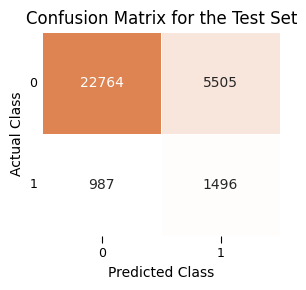

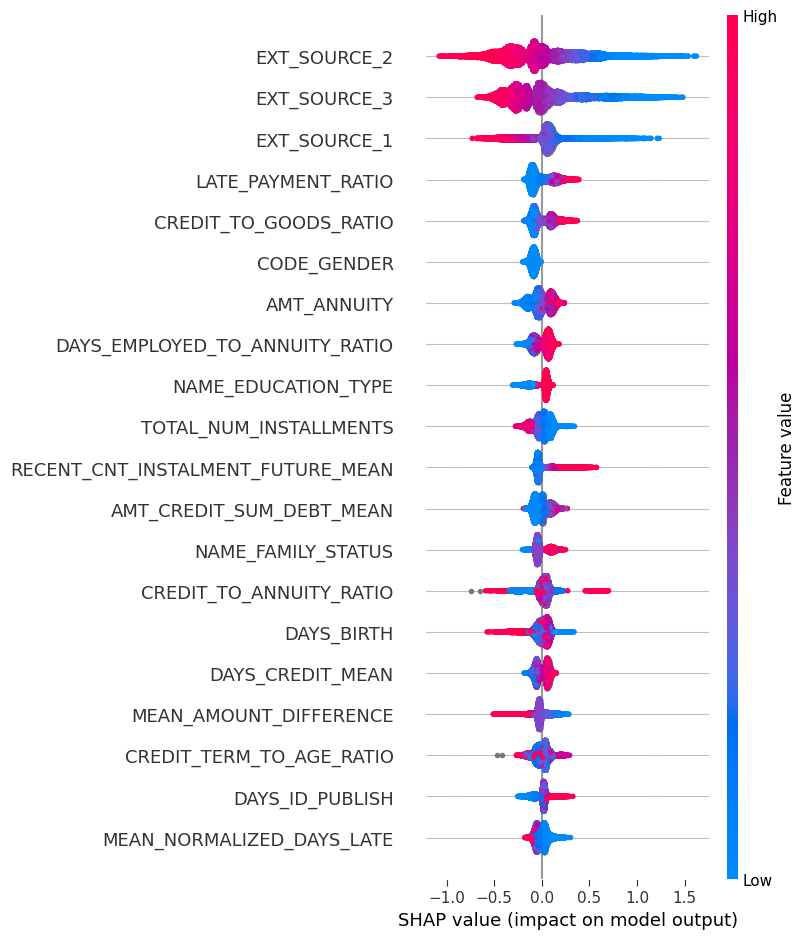

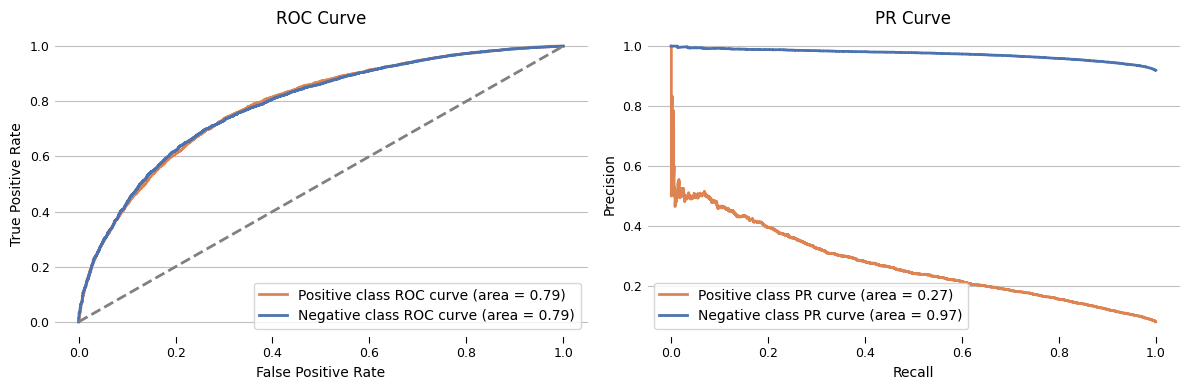

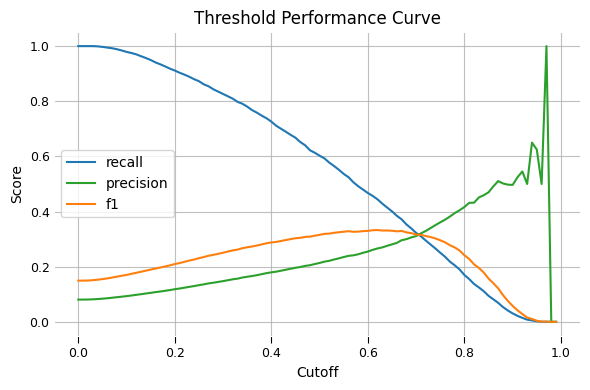

In [ ]:
X_test, y_test = feature_engineering_pipeline(
    application_test,
    previous_application_raw,
    bureau_raw,
    bureau_balance_raw,
    installments_payments_raw,
    pos_cash_balance_raw,
    credit_card_balance_raw,
)
y_pred = final_pipeline.predict(X_test)
y_pred_prob = final_pipeline.predict_proba(X_test)[:, 1]
result = {
    "model": "LightGBM",
    "roc_auc": roc_auc_score(y_test, y_pred_prob),
    "accuracy": accuracy_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
}
results_df = pd.DataFrame([result]).set_index("model")
results_df.index.name = None
print("Performance on the test data:")
display(results_df)

plot_confusion_matrix(y_test, y_pred)

preprocessor_returned = final_pipeline.named_steps["preprocessor"]
numeric_features = preprocessor_returned.transformers[0][2]
categorical_features = preprocessor_returned.transformers[1][2]
feature_names = np.concatenate([numeric_features, categorical_features])
classifier = final_pipeline.named_steps["classifier"]
X_transformed = preprocessor_returned.transform(X_test)
explainer = shap.TreeExplainer(classifier)
shap_values = explainer(X_transformed)
shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

plot_final_evaluation_curves(y_test, y_pred_prob)

As expected, the ROC-AUC on the test set (0.785356) is slightly lower than on the validation set, with a difference of around 0.05.

# Conclusions

Technical improvements:

- Use a data wrangling library with multiprocessing. Pandas proved too slow for some tasks due to its single-core processing. While I anticipated performance issues at the start of the project, the impact was larger than I expected. Switching to a library with multiprocessing capabilities would improve efficiency.
- Automate correlation-based feature removal. I would create a function to automatically drop features with a correlation above 0.99. Initially, I avoided automating this step due to uncertainty about thresholds and a wanted more manual control to observe model outcomes. Now that an approximate threshold is clear (0.99), automating this process would save considerable time and make SHAP feature importance more interpretable. This step would be performed before hyperparameter tuning.
- Incorporate Boruta for feature selection. Integrating Boruta would help identify relevant features earlier, reducing the time spent on repeated hyperparameter tuning required for SHAP-based feature selection. This step would follow bivariate feature removal or potentially replace it to avoid prematurely discarding relevant information.

Feature engineering:

- At the moment, I have explored four out of seven tables. In my opinion, this exploration was deep enough for the four of them, but I did not spend much time delving deeper into POS CASH Balance, Credit Card, and Bureau tables. This could lead to a more beneficial feature engineering.
- Explore different recent payment time frames, such as the last 3 recorded instances or the last 30. This would be the most beneficial fo the installments payments table.
- Try an imputation method such as IterativeImputer, which may be the best option for imputing missing values as it fills them based on the most similar instances. I tried KNN imputation, but it was extremely time-consuming, and I did not explore IterativeImputer afterwards.
- Create more ratios from the "application" table, as those provide the best performance improvements.
- Remove, replace, or flag all erroneous data I have identified and find additional problematic cases.

Feature engineering results:

- The most important features are from the "application" table and relate to the applicant and loan conditions, including both the features themselves and their ratios I engineered. These include the amount of credit granted, the cost of goods intended for purchase, gender, annuity amount, number of days employed, education level, family status, age, and occupation. Risk assessments from external sources were also among the most important.
- Of the 20 most important features (visible in the SHAP plot), only four are engineered from data outside the "application" table. These include the number of installments remaining on previous loans, the amount of credit previously lent, the amount of previous late payments, and how much less a person paid than agreed upon.

Other ideas:

- In this project, I spent some time researching the topic on my own, but it would have been more productive to focus on finding direct information related to this dataset and implementing proven techniques.
- Take a more pragmatic approach by aiming to achieve high enough scores with the least number of features, as this is probably the preferred approach in business.